# Quality analysis of crystallographic structures in the PDB

The following notebook presents the reproducible code for analyzing the quality of crystallographic structures in Protein Data Bank (PDB). The code contains comments concerning each step of the analysis that served as the basis for the paper **On the evolution of the quality of crystallographic models in the PDB** by Brzezinski *et al.*

The analysis was coded with Python 3.7.3. The environment specification is provided in the `requirements.txt` in the root of the GitHub repository (https://github.com/dabrze/pdb_structure_quality). The notebook makes use of the *Python markdown* and *Table of contents* nbextensions. It is advised to turn these extensions on before running the notebook.

In [122]:
# data wrangling and machine learning
import requests
import os
import numpy as np
import pandas as pd
import requests
import scipy.stats as ss
import scikit_posthocs as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_palette("deep")
from plotnine import *
import plotnine.options
plotnine.options.figure_size = (8, 4)

# utils
import itertools
import warnings
from IPython.display import display, Markdown

## Data acquisition and cleaning

The data for this analysis were taken from the PDB on December 10, 2019. To retrieve the data the following SQL query was run on PDBj (https://pdbj.org/mine):

In [123]:
with open("data/pdbj_query.txt", "r") as file:
    sql_query = file.read()
    
display(Markdown("``` mysql\n{0}\n```".format(sql_query)))

``` mysql
SELECT b.pdbid as "PDB code", r.ls_d_res_high as "Resolution", b.deposition_date as "Deposition date", r."ls_R_factor_R_work" as "R", r."ls_R_factor_R_free" as "R free", g.all_atom_clashscore as "Clashscore", g.rotamer_outliers_percent as "Rotamer outliers [%]", g."Ramachandran_outlier_percent" as  "Ramachandran outliers [%]", m."RSRZ_outliers_percent" as "RSRZ outliers [%]", r2.pdbx_number_atoms_protein as "Protein residues", r2.pdbx_number_atoms_nucleic_acid "Nucleic acids residues", b.citation_journal_pri "Journal", c."journal_id_ISSN" as "ISSN", c."journal_id_CSD" as "Journal CSD Id", c.year as "Publication year"
FROM brief_summary b
   left outer join refine r on r.pdbid = b.pdbid
   left outer join refine_hist r2 on r2.pdbid = b.pdbid
   left outer join citation c on (c.pdbid = b.pdbid and c.id = 'primary')
   left outer join vrpt.pdbx_dcc_geometry g on g.pdbid = b.pdbid
   left outer join vrpt.pdbx_dcc_density d on d.pdbid = b.pdbid
   left outer join vrpt.pdbx_dcc_map_overall m on m.pdbid = b.pdbid
WHERE r.ls_d_res_high is not null 
   AND r.pdbx_refine_id = 'X-RAY DIFFRACTION'
ORDER BY b.deposition_date 
```

The result of this query is saved to the `data` folder of this repository. The resulting `pdb_quality.csv` file contains information about:
    - the PDB code of the structure, 
    - crystallographic resolution, 
    - date of deposition
    - R work
    - R free,
    - Clashscore,
    - Percentage of rotamer outliers, 
    - Percentage of ramachandran outliers,
    - Percentage of RSRZ outliers,
    - number of protein residues,
    - number of nucleic acid residues,
    - journal name of the primary structure citation, 
    - journal ISSN,
    - journal CSD ID.
    
The following code reads the above-mentioned dataset into a pandas dataframe. For comparison purposes, the list of unique journal names prior to any normalization will be saved to `unique_journals_before.csv` in the `results` folder.

*To re-run the query (and get fresh data from the PDB) you can uncomment the marked code fragment.*

In [124]:
def query_pdbj(sql, data_format, dest_file):
    pdbj_rest_url = "https://pdbj.org/rest/mine2_sql"
    params = {
        "q": sql,
        "format": data_format,
    }

    response = requests.get(pdbj_rest_url, params)
    response.raise_for_status()

    directory = os.path.dirname(dest_file)
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(dest_file, 'wb') as handle:
        for block in response.iter_content(2048):
            handle.write(block) 

In [125]:
data_file = "data/pdb_quality.csv"
# # # # 
# query_pdbj(sql_query, "csv", data_file) # uncomment to re-run the PDB query
# # # #
quality_df_raw = pd.read_csv(data_file, na_values="", keep_default_na=False)

raw_journal_count = len(quality_df_raw.Journal.unique())
pd.DataFrame(quality_df_raw.Journal.unique(), columns=["Journal"]).sort_values("Journal").to_csv("results/unique_journals_before.csv", index=False)

Prior to any analysis, the data needs to be preprocessed. We will remove duplicates and non X-ray structures (if present) and perform preliminary journal name unification by removing punctuation from journal names. The following code performs the described tasks.

In [126]:
def unify_names_based_on_issn(df):
    journal_catalog = {}
    grouped_df = df.groupby(["ISSN", "Journal"])

    for name, group in grouped_df:
        issn = name[0]
        journal_name = name[1]

        if issn not in journal_catalog:
            journal_catalog[issn] = journal_name
        else:
            df.loc[df.loc[:, "ISSN"] == issn, "Journal"] = journal_catalog[issn]


def clean_quality_data(df):
    cleaned_df = df.copy()
    print("---------------------------")
    print("PDB structure quality dataset")
    print("---------------------------")
    print("Initial number of structures: %d" % cleaned_df.shape[0])

    duplicates = cleaned_df.duplicated("PDB code", keep="first")
    print("Found {0} duplicates: {1}".format(np.sum(duplicates), cleaned_df.loc[duplicates, "PDB code"].values))
    cleaned_df = cleaned_df.drop_duplicates("PDB code")
    cleaned_df = cleaned_df.set_index("PDB code")

    cleaned_df.loc[:, "Year"] = cleaned_df.loc[:, "Deposition date"].apply(str).str.slice(stop=4).apply(int)
    cleaned_df.loc[:, "Deposition date"] = pd.to_datetime(cleaned_df.loc[:, "Deposition date"], format="%Y-%m-%d", errors='ignore').dt.date
    cleaned_df.loc[:, "Contains protein"] = (cleaned_df.loc[:, "Protein residues"] != 0) | ~(cleaned_df.loc[:, "Ramachandran outliers [%]"].isna())
    cleaned_df.loc[:, "R [%]"] = cleaned_df.loc[:, "R"] * 100
    cleaned_df.loc[:, "R free [%]"] = cleaned_df.loc[:, "R free"] * 100
    cleaned_df.loc[:, "Contains protein"] = cleaned_df.loc[:, "Protein residues"] != 0
    cleaned_df = cleaned_df.drop(["Protein residues", "Nucleic acids residues", "R", "R free"], axis=1)
    
    cleaned_df.loc[cleaned_df.Journal.isna(), "Journal"] = "TO BE PUBLISHED"
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.upper()
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace(".", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace(",", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace("   ", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace("  ", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.strip()
    unify_names_based_on_issn(cleaned_df)
    
    print("Final number of structures: %d" % cleaned_df.shape[0])
    print("---------------------------")
    print("")

    return cleaned_df


def describe(df, rows=5):
    display(df.head(rows).style.format({
        'R': "{:.3f}",
        'R free': "{:.3f}",
        'RSR Z-score': "{:.2f}",
        'Rotamer outliers': "{:.2f}",
        'Ramachandran outliers': "{:.2f}",
        'Clashscore': "{:.2f}",
        'Resolution': "{:.2f}",
    }))
    print("Dataset rows: {}".format(df.shape[0]))
    print("Dataset columns: {}".format(df.shape[1]))

In [127]:
full_quality_df = clean_quality_data(quality_df_raw)
issn_and_name_unification_journal_count = len(full_quality_df.Journal.unique())

---------------------------
PDB structure quality dataset
---------------------------
Initial number of structures: 141155
Found 1 duplicates: ['5dpn']
Final number of structures: 141154
---------------------------



The provided data describes **{{full_quality_df.shape[0]}} PDB deposits** by their PDB code, resolution, deposition date several quality metrics. The attached journal data initially contained {{raw_journal_count}} journal names. After correcting punctuation and whitespace errors, and name unification using ISSNs, the number of unique journal names **went down to {{issn_and_name_unification_journal_count}}**.

The first rows of the dataframe containing information about structure quality and journal publications are presented below.

In [128]:
describe(full_quality_df)

,Resolution,Deposition date,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],Journal,ISSN,Journal CSD Id,Publication year,Year,Contains protein,R [%],R free [%]
PDB code,,,,,,,,,,,,,,
1sbt,2.50,1972-08-11,95.46,10.730000,6.590000,nan,BIOCHEM BIOPHYS RES COMMUN,0006-291X,146.000000,1971.000000,1972,True,nan,nan
1mbn,2.00,1973-04-05,54.11,15.200000,3.310000,nan,PROG STEREOCHEM,0079-6808,419.000000,1969.000000,1973,True,nan,nan
2dhb,2.80,1973-11-01,26.21,15.090000,5.650000,nan,NATURE,0028-0836,6.000000,1970.000000,1973,True,nan,nan
3ldh,3.00,1974-06-06,189.76,39.860000,14.630000,nan,J MOL BIOL,0022-2836,70.000000,1976.000000,1974,True,nan,nan
2cha,2.00,1975-01-01,23.29,16.670000,1.730000,nan,J MOL BIOL,0022-2836,70.000000,1972.000000,1975,True,nan,nan


Dataset rows: 141154
Dataset columns: 14


## Journal name unification

To analyze and visualize the relation between structure quality and journals, the journal names have to be unified. Even after removing punctuation, several journal names have more than one name in the PDB. The main causes of this situation are:

- there is more than one way of abbreviating a journal name (e.g., CHEM BIO CHEM vs CHEMBIOCHEM),
- the journal changed its name over time (e.g., EUR J BIOCHEM vs FEBS J),
- ISSN and CSD ids are sometimes missing.

To deal with this situation we used the Levenstein distance to look for pairs of journal names that differ by 4 or less edits. This way we inspected journal names with potential typos or ambiguous abbreviations. To find journals that changed their name, we looked for journals with several structures published, that stopped publishing for at least two years having at least five distinct years with published structures, and analyzed if they changed their names.

The code below performs the analysis. The journal name pairs with Levenstein distance 4 or less were saved to `levelstein.csv` and the list of "disappearing" journals to `disappearing.csv`. The journal name mapping that resulted from manual inspection of these lists and Web of Science data was saved to `journal_mapping.csv`. Finally, the list of unique journal names after the entire process of name unification can be found in the `unique_journals_after.csv` file.

In [129]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]


def create_levenstein_journal_list(journal_df):
    unique_journal_names = journal_df.loc[:, "Journal"].unique()
    pairs_df = pd.DataFrame(itertools.combinations(unique_journal_names, 2), columns=['J1', 'J2'])
    pairs_df = pairs_df.loc[(~pairs_df.J1.isna()) & (~pairs_df.J2.isna()), :]
    pairs_df.loc[:, "L"] = 0
    pairs_df.loc[:, "L"] = pairs_df.apply(lambda x: levenshtein(x.J1, x.J2), axis=1)
    
    return pairs_df

def create_disappearing_journal_list(journal_df, min_years_ago=2, min_year_count=5):
    grouped_df = journal_df.groupby(["Journal", "Publication year"])
    unique_journals = journal_df.loc[:, ["Journal", "ISSN"]].drop_duplicates(subset=["Journal"])
    
    journals = []
    min_years = []
    max_years = []
    counts = []

    for name, group in grouped_df:
        journal_name = name[0]
        year = name[1]

        if journal_name not in journals:
            journals.append(journal_name)
            min_years.append(year)
            max_years.append(year)
            counts.append(1)
        else:
            if year > max_years[-1]:
                max_years[-1] = year
           
            if year < min_years[-1]:
                min_years[-1] = year
                
            counts[-1] = counts[-1] + 1


    disappearing_df = pd.DataFrame({"Journal": journals, "Min": min_years, "Max": max_years, "Count": counts})
    disappearing_df.loc[:, "YearsAgo"] = 2018 - disappearing_df.Max
    
    disappearing_df = disappearing_df.loc[(disappearing_df.YearsAgo >= min_years_ago) & (disappearing_df.Count >= min_year_count), :]
    disappearing_df = pd.merge(disappearing_df, unique_journals, on="Journal", how="left")
    
    return disappearing_df.sort_values("Count", ascending=False)

In [130]:
max_levenstein_distance = 4

levenstein_journals_df = create_levenstein_journal_list(full_quality_df)
levenstein_journals_df.loc[levenstein_journals_df.L <= max_levenstein_distance, :].to_csv("results/levelstein.csv")

disappearing_journals_df = create_disappearing_journal_list(full_quality_df)
disappearing_journals_df.to_csv("results/disappearing.csv")

In [131]:
mapping_df = pd.read_csv("data/journal_mapping.csv", index_col=False)
mapping_dict = mapping_df.set_index('From')["To"].to_dict()

full_quality_df = full_quality_df.replace(mapping_dict).copy()
full_quality_df = full_quality_df.drop(["Journal CSD Id", "Publication year"], axis=1)

unique_journals_df = pd.DataFrame(full_quality_df.Journal.unique(), columns=["Journal"]).sort_values("Journal")
unique_journals_df.to_csv("results/unique_journals_after.csv", index=False)

The entire process of data cleaning (disappearing journals, levenstein distance, manual inspection) resulted in **{{unique_journals_df.shape[0]}} unique journal names**.

## Missing data imputation

Unfortunately, not all PDB deposits have all quality metrics calculated.

In [132]:
quality_metrics_df = full_quality_df.loc[:, ["Resolution", "Year", "Clashscore", "Ramachandran outliers [%]", 
                                             "Rotamer outliers [%]", "RSRZ outliers [%]", "R [%]", "R free [%]"]]
quality_column_nan_ratios = quality_metrics_df.isna().sum() / quality_metrics_df.shape[0]
display(quality_column_nan_ratios.to_frame(name="Missing values").style.format('{:.2%}'))

quality_not_nan_filter = quality_metrics_df.index.isin(quality_metrics_df.dropna().index)
quality_not_nan_df = quality_metrics_df[quality_not_nan_filter]
quality_nan_df = quality_metrics_df[~quality_not_nan_filter]

quality_not_nan_ratio = quality_not_nan_df.shape[0] / quality_metrics_df.shape[0]
quality_nan_ratio = 1 - quality_not_nan_ratio

,Missing values
Resolution,0.00%
Year,0.00%
Clashscore,0.10%
Ramachandran outliers [%],1.69%
Rotamer outliers [%],1.72%
RSRZ outliers [%],9.56%
R [%],2.39%
R free [%],4.29%


The above analysis shows that practically each quality metric has missing values, with {{(quality_column_nan_ratios.loc["RSRZ outliers [%]"]/(1/100.0)).round(2)}}% PDB deposits missing their RSR Z-score. Overall, there are **{{round(quality_nan_ratio * 100, 2)}}% deposits with at least one quality metric missing**.

One could continue the analysis by omitting PDB deposits with incomplete data or try to impute missing values. Since the analyzed quality metrics are to some extent correlated with each other. We will attempt both approaches. 

Before imputing missing values, we first present the histograms for each quality metric and calculate their standard deviations, to get a gist of acceptable imputation error for each metric.

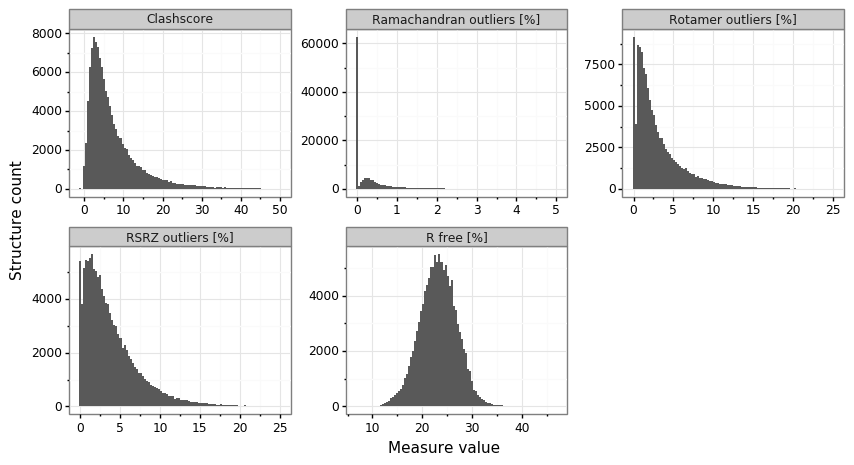

In [466]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_plot = full_quality_df.copy()
    df_plot = df_plot.loc[(df_plot.Clashscore <= 50) & # limiting data range to increase readability
                          (df_plot.loc[:, "RSRZ outliers [%]"] <= 25) &
                          (df_plot.loc[:, "Rotamer outliers [%]"] <= 25) &
                          (df_plot.loc[:, "Ramachandran outliers [%]"] <= 5), :].copy() 
    df_plot = pd.melt(df_plot, id_vars=None,
                      value_vars=["Clashscore", "RSRZ outliers [%]", "Ramachandran outliers [%]",
                                  "Rotamer outliers [%]", "R free [%]"])
    measure_cat = pd.Categorical(df_plot['variable'], categories=["Clashscore", "Ramachandran outliers [%]",
                                  "Rotamer outliers [%]", "RSRZ outliers [%]",  "R free [%]"])
    df_plot = df_plot.assign(variable = measure_cat)

    p = ggplot(aes(x='value'), df_plot) + \
        geom_histogram(bins=100) + \
        theme_bw() + \
        facet_wrap("~variable", ncol=3, scales="free") + \
        ylab("Structure count") +\
        xlab("Measure value") +\
        theme(figure_size=(10, 5), panel_spacing_x=0.55,
              panel_spacing_y=0.3, legend_position="none",
              axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black"))

    p.save("results/images/distributions.svg")
    p.save("results/images/distributions.pdf")
    p.draw();

In [134]:
display(quality_not_nan_df.mean().to_frame(name="Mean").style.format("{:.3f}"))

,Mean
Resolution,2.132
Year,2011.478
Clashscore,8.035
Ramachandran outliers [%],0.493
Rotamer outliers [%],3.256
RSRZ outliers [%],4.045
R [%],19.314
R free [%],23.348


In [135]:
display(quality_not_nan_df.std().to_frame(name="Standard deviation").style.format("{:.3f}"))

,Standard deviation
Resolution,0.559
Year,5.105
Clashscore,9.112
Ramachandran outliers [%],1.259
Rotamer outliers [%],3.651
RSRZ outliers [%],4.060
R [%],3.249
R free [%],3.823


We will test three approaches to missing data imputation:

- filling missing values with the metric's mean value;
- filling missing values with the metric's median;
- using the iterative data imputation method of S.F. Buck described in _"A Method of Estimation of Missing Values in Multivariate Data Suitable for use with an Electronic Computer"_ with Bayesian ridge regression as the predictor. We used Bayesian ridge regression as it is a parameterless method that does not require tuning, and it was shown to perform well on such tasks.

To see how well each of the methods perform, we used the non-missing portion of the PDB data. We randomly introduced missing values to this (complete) test dataset in the same proportions as those present in the dataset, i.e., there was the same proportion of deposits with at least one missing value and the same percentage of missing values per metric as in the original (full) dataset. Next, imputed these randomly introduced missing values and compared the result with values originally present in the dataset. To quantify the imputation error we used the median absolute deviation (MAD), mean absolute error (MAE), and root mean-squared error (RMSE). The procedure was repeated 100 times, to get a better estimation of the performance of each algorithm.

In [136]:
measure_columns = ["Clashscore", "Ramachandran outliers [%]", "Rotamer outliers [%]", "RSRZ outliers [%]", "R [%]", "R free [%]"]

def clip_imputed_values_at_zero(df):
    for measure_column in measure_columns:
        df.loc[df.loc[:, measure_column] < 0, measure_column] = 0
        
    return df

In [137]:
def introduce_random_nans(df, total_nan_pct, column_nan_pct, seed):
    naned_df = df.copy()
    potential_nan_idxs = naned_df.sample(frac=total_nan_pct, random_state=seed).index
    i = seed

    for col in naned_df:
        col_frac = column_nan_pct[col] / total_nan_pct
        #print("{0}: {1}/{2} = {3}".format(col,  column_nan_pct[col], total_nan_pct, col_frac))
        vals_to_nan = naned_df.loc[potential_nan_idxs, col].sample(frac=col_frac, random_state=i).index
        naned_df.loc[vals_to_nan, col] = np.NaN
        i = i + 1

    return naned_df

results_df = pd.DataFrame()

for i in range(100):
    test_df = introduce_random_nans(quality_not_nan_df, quality_nan_ratio, quality_column_nan_ratios, seed=i)
    test_idx = test_df.isna()
 
    for name, imputer in [
        ("Mean", SimpleImputer(strategy="mean")),
        ("Median", SimpleImputer(strategy="median")),
        ("Bayesian", IterativeImputer(random_state=23, max_iter=10))
    ]:       
        df_imputed = pd.DataFrame(imputer.fit_transform(test_df), columns=test_df.columns, index=test_df.index)
        df_imputed = clip_imputed_values_at_zero(df_imputed)
        
        for col in test_df:
            if test_df[col].isna().any():
                for measure, func in [("MSE", mean_squared_error), 
                                      ("MAE", mean_absolute_error),
                                      ("MAD", median_absolute_error)]:
                    y_true = quality_not_nan_df.loc[test_idx[col], col]
                    y_pred = df_imputed.loc[test_idx[col], col]
        
                    results_df = results_df.append(pd.DataFrame({"Experiment": [i], "Method": [name], "Column": [col],
                                                                 "Measure": [measure], "Value": [func(y_true, y_pred)]}))

results_df.to_csv("results/imputer_evaluation_results.csv", index=False)

Below we present the results of the experiment. It can be noticed that the iterative imputation method outperformed the remaining simple methods on practically all the metrics, achieving usually around half of the error. The mean absolute error is usually two to three times smaller than the standard deviation of each metric.

In [138]:
def highlight_min(s):
    is_min = (
        (s == s.loc[results_df_pivot.index.get_level_values("Measure") == "MAD", :].min()) |
        (s == s.loc[results_df_pivot.index.get_level_values("Measure") == "MAE", :].min()) |
        (s == s.loc[results_df_pivot.index.get_level_values("Measure") == "RMSE", :].min())
             )
    return ['font-weight: bold; color: green' if v else '' for v in is_min]

results_df = pd.read_csv("results/imputer_evaluation_results.csv")
results_df.loc[results_df.Measure == "MSE", "Value"] = np.sqrt(results_df.loc[results_df.Measure == "MSE", "Value"])
results_df.loc[results_df.Measure == "MSE", "Measure"] = "RMSE"

results_df_pivot = results_df.pivot_table(index=["Measure", "Method"], columns="Column", values="Value",
                                          aggfunc=["mean"] )
results_df_pivot.to_csv("results/imputer_evaluation_results_summary.csv", index=False)
results_df_pivot.round(2).style.apply(highlight_min)

The standard deviations of the errors are presented below. It can be noticed that iterative imputation not only is more accurate but has a substantially lower prediction variance.

In [139]:
results_df.pivot_table(index=["Measure", "Method"], columns="Column", values="Value", aggfunc=["std"] ).round(2)

std                                     \
Column           Clashscore R [%] R free [%] RSRZ outliers [%]   
Measure Method                                                   
MAD     Bayesian       0.29  0.02       0.02              0.02   
        Mean           0.31  0.04       0.04              0.02   
        Median         0.28  0.04       0.04              0.02   
MAE     Bayesian       0.44  0.02       0.02              0.03   
        Mean           0.64  0.04       0.03              0.03   
        Median         0.72  0.04       0.03              0.03   
RMSE    Bayesian       1.48  0.04       0.03              0.15   
        Mean           2.32  0.06       0.04              0.14   
        Median         2.42  0.06       0.04              0.14   

                                                                 
Column           Ramachandran outliers [%] Rotamer outliers [%]  
Measure Method                                                   
MAD     Bayesian                      0.01                 0.03  
        Mean                          0.00                 0.04  
        Median                        0.01                 0.04  
MAE     Bayesian                      0.02                 0.04  
        Mean                          0.02                 0.06  
        Median                        0.03                 0.07  
RMSE    Bayesian                      0.11                 0.10  
        Mean                          0.16                 0.14  
        Median                        0.16                 0.15

Below the p-values for the non-parametric Friedman and Nemenyi tests verifying whether the differences between the performances of methods are statistically significant.

In [140]:
methods = ["Bayesian", "Mean", "Median"]

for error in ["MAD", "MAE", "RMSE"]:
    print("----")
    print(error)
    print("----")
    for metric in measure_columns:
        experiment_results = [results_df.loc[(results_df.Method == method) & 
                                             (results_df.Measure == error) & 
                                             (results_df.Column == metric), "Value"].tolist() 
                              for method in methods]
        F_p = ss.friedmanchisquare(*experiment_results)[1]
        N_ps = sp.posthoc_nemenyi_friedman(np.array(experiment_results).T)
        N_ps.columns = methods
        N_ps.index = methods
        print("{0}: Friedman p-value={1:.4f}, Nemenyi p-values=\n{2}".format(metric, F_p, N_ps))
        print("")

----
MAD
----
Clashscore: Friedman p-value=0.0000, Nemenyi p-values=
          Bayesian   Mean  Median
Bayesian    -1.000  0.001   0.001
Mean         0.001 -1.000   0.001
Median       0.001  0.001  -1.000

Ramachandran outliers [%]: Friedman p-value=0.0000, Nemenyi p-values=
          Bayesian   Mean  Median
Bayesian    -1.000  0.001   0.001
Mean         0.001 -1.000   0.001
Median       0.001  0.001  -1.000

Rotamer outliers [%]: Friedman p-value=0.0000, Nemenyi p-values=
          Bayesian   Mean  Median
Bayesian    -1.000  0.001   0.001
Mean         0.001 -1.000   0.001
Median       0.001  0.001  -1.000

RSRZ outliers [%]: Friedman p-value=0.0000, Nemenyi p-values=
          Bayesian   Mean  Median
Bayesian    -1.000  0.001   0.001
Mean         0.001 -1.000   0.001
Median       0.001  0.001  -1.000

R [%]: Friedman p-value=0.0000, Nemenyi p-values=
          Bayesian      Mean    Median
Bayesian    -1.000  0.001000  0.001000
Mean         0.001 -1.000000  0.029378
Median       0.001 

Therefore, we will use the iterative imputation method to fill missing values in the PDB dataset and gain a larger set of PDB deposits for analysis. Later in the analysis, we will compare results obtained using the dataset with missing values removed and with imputed missing values. Below a sample of the imputed dataset.

We note that imputed values that went out of range (e.g. % outliers lower < 0) were clipped to zero. Moreover, values that should not be imputed (e.g. Ramachandran outliers for nucleic acids) were left missing.

In [142]:
best_imputer = IterativeImputer(random_state=23, max_iter=10)

tmp_df = full_quality_df.drop(["Deposition date", "Journal", "ISSN"], axis=1)
full_quality_imputed_df = pd.DataFrame(best_imputer.fit_transform(tmp_df), columns=tmp_df.columns, index=full_quality_df.index)
full_quality_imputed_df.loc[:, "Deposition date"] = full_quality_df.loc[:, "Deposition date"]
full_quality_imputed_df.loc[:, "Journal"] = full_quality_df.loc[:, "Journal"]
full_quality_imputed_df.loc[:, "ISSN"] = full_quality_df.loc[:, "ISSN"]
full_quality_imputed_df.loc[:, "Contains protein"] = full_quality_df.loc[:, "Contains protein"].astype("bool")
full_quality_imputed_df.loc[(~full_quality_imputed_df.loc[:, "Contains protein"]), "Ramachandran outliers [%]"] = np.nan
full_quality_imputed_df.loc[(~full_quality_imputed_df.loc[:, "Contains protein"]), "Rotamer outliers [%]"] = np.nan

full_quality_imputed_df = clip_imputed_values_at_zero(full_quality_imputed_df)

In [143]:
describe(full_quality_imputed_df)

,Resolution,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],Year,Contains protein,R [%],R free [%],Deposition date,Journal,ISSN
PDB code,,,,,,,,,,,,
1sbt,2.50,95.46,10.730000,6.590000,5.794077,1972.000000,True,25.960733,31.663298,1972-08-11,BIOCHEM BIOPHYS RES COMMUN,0006-291X
1mbn,2.00,54.11,15.200000,3.310000,4.781674,1973.000000,True,22.109731,28.254517,1973-04-05,PROG STEREOCHEM,0079-6808
2dhb,2.80,26.21,15.090000,5.650000,4.279127,1973.000000,True,23.245285,29.884926,1973-11-01,NATURE,0028-0836
3ldh,3.00,189.76,39.860000,14.630000,9.071444,1974.000000,True,32.423844,40.723698,1974-06-06,J MOL BIOL,0022-2836
2cha,2.00,23.29,16.670000,1.730000,3.979372,1975.000000,True,20.410695,26.850902,1975-01-01,J MOL BIOL,0022-2836


Dataset rows: 141154
Dataset columns: 12


## Overall quality percentile rank computation (Q1)

In this part of the analysis we will try to reproduce the methodology of Shao _et al._ presented in _"Multivariate Analyses of Quality Metrics for Crystal Structures in the PDB Archive"_. As was done in the paper, we will start by performing a **PCA analysis** on three raw quality metrics: **Clashscore**, **Ramachandran outliers** and **Rotamer outliers**. Since Ramachandran outliers and Rotamer outliers are valid only for proteins, the PCA analysis will be limited to proteins. To asses the quality of nucleic acid structures, PCA will not be needed.

In [144]:
protein_df = full_quality_df.loc[full_quality_df.loc[:, "Contains protein"], :]
nucleic_df = full_quality_df.loc[~full_quality_df.loc[:, "Contains protein"], :]

protein_imputed_df = full_quality_imputed_df.loc[full_quality_imputed_df.loc[:, "Contains protein"], :]
nucleic_imputed_df = full_quality_imputed_df.loc[~full_quality_imputed_df.loc[:, "Contains protein"], :]

In [145]:
pca_columns = ["Clashscore", "Ramachandran outliers [%]", "Rotamer outliers [%]"]
protein_df_filtered_columns = protein_df.loc[:, pca_columns]

The raw data are set on different scales and containg a couple of strong outliers (as can been seen on the plot below).

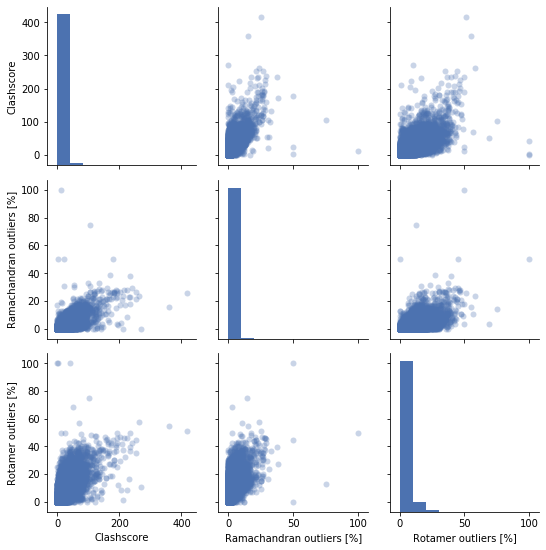

In [147]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.pairplot(protein_df_filtered_columns, kind='scatter', plot_kws={'alpha':0.3, 'linewidth':0})
    g.savefig("results/images/pca_metrics.png", dpi=600)

After removing strong outliers and standardizing the data (setting the mean to be 0 and standard deviation to 1), the data presents itself as follows.

In [148]:
outlier_filter = protein_df_filtered_columns[(protein_df_filtered_columns.loc[:, "Rotamer outliers [%]"] > 50) | 
                                             (protein_df_filtered_columns.loc[:, "Ramachandran outliers [%]"] > 45) | 
                                             (protein_df_filtered_columns.loc[:, "Clashscore"] > 250)].index
print("Number of outliers: {0}".format(len(outlier_filter)))
print("Outliers: {0}".format(sorted(list(protein_df_filtered_columns.loc[outlier_filter, :].index))))
df_filtered = protein_df_filtered_columns.drop(outlier_filter, axis=0)

scaler = StandardScaler()
scaler.fit(df_filtered)
df_rescaled = scaler.transform(df_filtered)
df_rescaled = pd.DataFrame(df_rescaled, columns=pca_columns)
df_rescaled.head()

Number of outliers: 16
Outliers: ['1c4d', '1dh3', '1g3x', '1hds', '1hkg', '1hpb', '1pyp', '1sm1', '2abx', '2gn5', '2ogm', '2y3j', '3zs2', '4bm5', '4hiv', '5m2k']


,Clashscore,Ramachandran outliers [%],Rotamer outliers [%]
0,8.180162,4.222831,1.695442
1,4.275769,1.921703,2.765405
2,1.641366,3.563361,2.739075
3,17.084257,9.863399,8.668158
4,1.365650,0.813234,3.117273


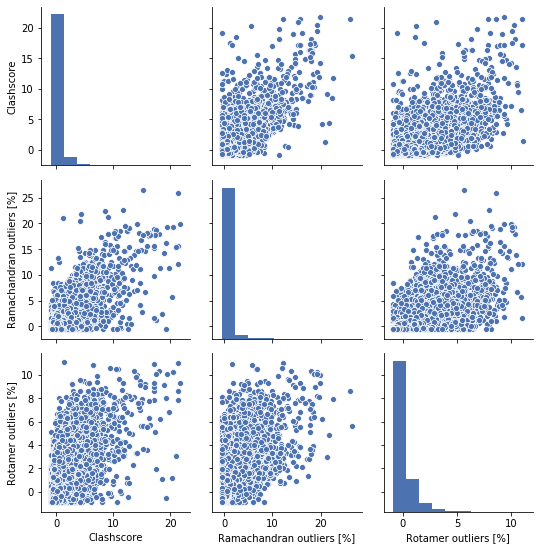

In [149]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.pairplot(df_rescaled)

In [150]:
pca = PCA(svd_solver="full")
pca.fit(df_rescaled.dropna())
principal_components =pca.transform(df_rescaled.dropna())
df_pca = pd.DataFrame(data = principal_components, columns = ['PC 1', 'PC 2', 'PC3'])
df_pca.head()

,PC 1,PC 2,PC3
0,8.268654,2.747949,3.423765
1,5.204936,-0.233421,1.577319
2,4.562863,0.120987,-1.438962
3,20.726658,2.188201,5.473759
4,3.022956,-1.761934,-0.073111


Running Principle Component Analysis on the standardized data results in three principle components PC 1, PC 2, PC 3, explaining 78%, 14%, 8% variance, respectively.

In [151]:
pca.explained_variance_ratio_

array([0.77454896, 0.14088749, 0.08456355])

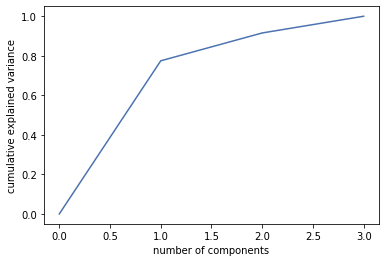

In [152]:
variance = np.array([0])
variance = np.append(variance, np.cumsum(pca.explained_variance_ratio_))
plt.plot(variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The eigenvectors of each principle component (presented below) show the linear combination coefficients of each quality measure.

In [153]:
df_eigen_vectors = pd.DataFrame(pca.components_,columns=df_rescaled.columns,index = ['PC 1','PC 2', 'PC 3'])
df_eigen_vectors

,Clashscore,Ramachandran outliers [%],Rotamer outliers [%]
PC 1,0.597509,0.576659,0.557177
PC 2,0.217604,0.552170,-0.804833
PC 3,0.771771,-0.602139,-0.204443


**The result obtained in this analysis (explained variance of each principle component, coefficients (eigenvecor) of the first pronciple component) are almost identical to those presented in _"Multivariate Analyses of Quality Metrics for Crystal Structures in the PDB Archive"_ by Shao _et al._**

After performing the PCA analysis, we can compute the Q1 metric for all deposits in the PDB. For proteins we will use the PCA component in the formula, whereas for nucleic acids we will substitute PC 1 with Clashscore. Below a sample of the modified datasets: one without missing values and the other with imputed missing values.

In [155]:
protein_metrics = list(pca_columns)
protein_metrics.extend(["R free [%]", "RSRZ outliers [%]"])
nucleic_metrics = ["R free [%]", "RSRZ outliers [%]", "Clashscore"]

def add_Q1(df, scale_transformer, pca_transformer, proteins):   
    if proteins:
        full_df = df.copy().dropna(subset=protein_metrics)
        pca_df = pd.DataFrame(data=pca.transform(scaler.transform(full_df.loc[:, pca_columns])), 
                              columns=['PC1', 'PC2', 'PC3'],
                              index=full_df.index)
        pc1_p = pca_df.loc[:, "PC1"].rank(pct=True, ascending=False)
    else:
        full_df = df.copy().dropna(subset=nucleic_metrics)
        pc1_p = full_df.loc[:, "Clashscore"].rank(pct=True, ascending=False)
        
    rfree_p = full_df.loc[:, "R free [%]"].rank(pct=True, ascending=False)
    zscore_p = full_df.loc[:, "RSRZ outliers [%]"].rank(pct=True, ascending=False)
    
    full_df.loc[:, "Q1"] = (pc1_p + rfree_p + zscore_p) / 3.0
    full_df.loc[:, "Q1_min"] =  pd.concat([pc1_p, rfree_p, zscore_p], axis=1).min(axis=1)
    full_df.loc[:, "Q1 percentile"] = full_df.loc[:, "Q1"].rank(pct=True)
    full_df.loc[:, "Q1_min percentile"] = full_df.loc[:, "Q1_min"].rank(pct=True)
    
    return full_df
    
protein_q1_df = add_Q1(protein_df, scaler, pca, proteins=True)
protein_imputed_q1_df = add_Q1(protein_imputed_df, scaler, pca, proteins=True)
nucleic_q1_df = add_Q1(nucleic_df, scaler, None, proteins=False)
nucleic_imputed_q1_df = add_Q1(nucleic_imputed_df, scaler, None, proteins=False)

describe(protein_q1_df)
describe(protein_imputed_q1_df)

,Resolution,Deposition date,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],Journal,ISSN,Year,Contains protein,R [%],R free [%],Q1,Q1_min,Q1 percentile,Q1_min percentile
PDB code,,,,,,,,,,,,,,,,
1crb,2.10,1993-02-10,3.14,0.000000,0.000000,0.000000,J MOL BIOL,0022-2836,1993,True,18.800000,24.800000,0.751799,0.345232,0.870131,0.625438
1pxt,2.80,1994-07-04,31.19,11.270000,3.270000,0.870000,STRUCTURE,0969-2126,1994,True,19.800000,33.400000,0.293280,0.007549,0.182660,0.020352
1csm,2.20,1994-08-22,9.03,4.890000,0.600000,0.200000,PNAS,0027-8424,1994,True,19.600000,31.000000,0.400821,0.022767,0.338968,0.059387
1cbr,2.90,1994-09-28,13.63,4.240000,1.490000,1.840000,STRUCTURE,0969-2126,1994,True,25.100000,32.000000,0.277132,0.014261,0.162983,0.037961
1cbs,1.80,1994-09-28,4.01,2.440000,0.000000,0.000000,STRUCTURE,0969-2126,1994,True,20.000000,23.700000,0.677110,0.457616,0.776442,0.752621


Dataset rows: 123798
Dataset columns: 16


,Resolution,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],Year,Contains protein,R [%],R free [%],Deposition date,Journal,ISSN,Q1,Q1_min,Q1 percentile,Q1_min percentile
PDB code,,,,,,,,,,,,,,,,
1sbt,2.50,95.46,10.730000,6.590000,5.794077,1972.000000,True,25.960733,31.663298,1972-08-11,BIOCHEM BIOPHYS RES COMMUN,0006-291X,0.080332,0.004847,0.011922,0.013134
1mbn,2.00,54.11,15.200000,3.310000,4.781674,1973.000000,True,22.109731,28.254517,1973-04-05,PROG STEREOCHEM,0079-6808,0.139395,0.015474,0.039894,0.040937
2dhb,2.80,26.21,15.090000,5.650000,4.279127,1973.000000,True,23.245285,29.884926,1973-11-01,NATURE,0028-0836,0.139332,0.019969,0.039837,0.052305
3ldh,3.00,189.76,39.860000,14.630000,9.071444,1974.000000,True,32.423844,40.723698,1974-06-06,J MOL BIOL,0022-2836,0.027349,0.000352,0.001488,0.001021
2cha,2.00,23.29,16.670000,1.730000,3.979372,1975.000000,True,20.410695,26.850902,1975-01-01,J MOL BIOL,0022-2836,0.204080,0.040340,0.089143,0.102259


Dataset rows: 139068
Dataset columns: 16


## Crystallographic structure quality analysis

### Q1 percentiles over time and resolution

We analyzed how structure PDB quality changed with time and structure resolution. Structures were grouped by deposition year and resolution rounded to one decimal place and capped at 4 Å. The visual analysis presented below shows that:

1. The quality of structures is very strongly connected with their resolution
2. The quality of PDB structures has improved over time (and is therefore time dependent)
3. The percentiles calculated using imputed data are almost identical to those calculated using only full deposits, but allows to view how the quality of the PDB changed throughout 45 rather than 25 years

In the following analysis of journals, we will use data with imputed missing values, and we will try to take into account deposition time and structure resolution.

In [709]:
def plot_q1_analysis(df, title, percentile_col="Q1 percentile", label="$P_{Q1}$ [%]", color="#EE7733"):
    plot_df = df.copy()
    plot_df = plot_df.rename(columns={percentile_col: percentile_col.replace(" ", "_")})
    percentile_col = percentile_col.replace(" ", "_")
    
    plot_df.loc[:, "Resolution"] = plot_df.loc[:, "Resolution"].round(decimals=1)
    plot_df.loc[:, percentile_col] = plot_df.loc[:, percentile_col] * 100
    plot_df.loc[plot_df.loc[:, "Resolution"] > 4, "Resolution"] = 4
    plot_df.loc[plot_df.loc[:, "Resolution"] < 1, "Resolution"] = 1
    year_df = plot_df.groupby(['Year'], as_index=False).mean()
    year_df_sem = plot_df.loc[:, ["Year", percentile_col]].groupby(['Year']).sem()
    year_df_sem = year_df_sem.rename(columns={percentile_col: "sem"})
    year_df = year_df.merge(year_df_sem, left_on="Year", right_index=True)
    count_df = plot_df.groupby(['Year'], as_index=False).count()
    resolution_df = plot_df.groupby(['Resolution'], as_index=False).mean()
    resolution_df_sem = plot_df.loc[:, ["Resolution", percentile_col]].groupby(['Resolution']).sem()
    resolution_df_sem = resolution_df_sem.rename(columns={percentile_col: "sem"})
    resolution_df = resolution_df.merge(resolution_df_sem, left_on="Resolution", right_index=True)
    count_res_df = plot_df.groupby(['Resolution'], as_index=False).count()
    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = (ggplot(resolution_df, aes(x="Resolution", y=percentile_col)) +
             geom_errorbar(width=0.01, size=0.75, mapping=aes(x="Resolution", ymin=percentile_col+"-sem",
                                       ymax=percentile_col+"+sem"), color="#9DA0A2") +
            geom_line(color=color) + 
             geom_point(color=color) +
             ylim(0, 100) + ylab(label) + 
             theme_classic() + xlab("Resolution [Å]") +
             theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black")))
        p.save("results/images/" + title + "_resolution.svg")
        p.save("results/images/" + title + "_resolution.pdf")
        p = p + labs(title=title)
        p.draw();

        p = (ggplot(count_res_df, aes(x="Resolution", y=percentile_col)) +
         geom_bar(stat="identity", fill=color) + ylab("Structure count") + 
             xlab("Resolution [Å]")  + theme_classic() +
             theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black")))
        p.save("results/images/" + title + "_count.svg")
        p.save("results/images/" + title + "_count.pdf")
        p.draw();

        p = (ggplot(year_df, aes(x="Year", y=percentile_col)) +
             geom_errorbar(width=0.01, size=0.75, mapping=aes(x="Year", ymin=percentile_col+"-sem",
                           ymax=percentile_col+"+sem"), color="#9DA0A2") + 
             geom_line(color=color) + 
             geom_point(color=color) + 
             xlim(1970, 2020) + ylim(0, 100) + ylab(label) + theme_classic() +
             theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black")))
        p.save("results/images/" + title + "_year.svg")
        p.save("results/images/" + title + "_year.pdf")
        p.draw();
                
#         (ggplot(count_df, aes(x="Year", y=percentile_col)) +
#          geom_bar(stat="identity") + xlim(1970, 2020)  + ylab("Structure count")+ theme_bw()).draw();

#### Proteins without data imputation

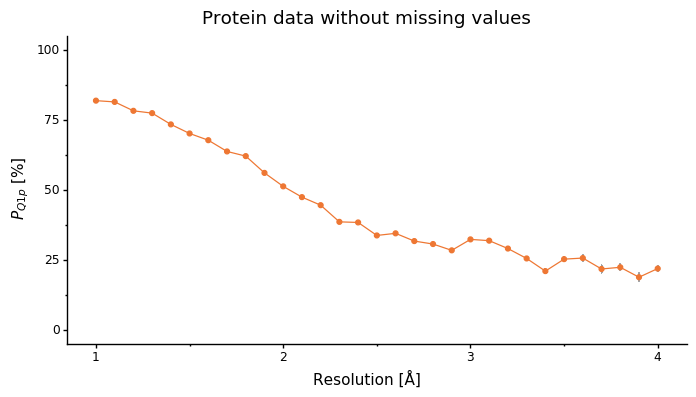

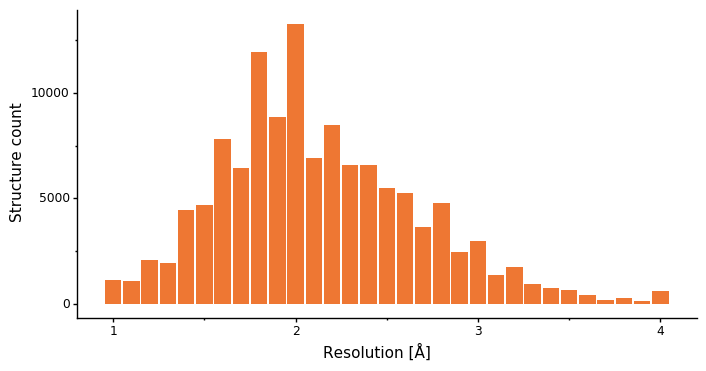

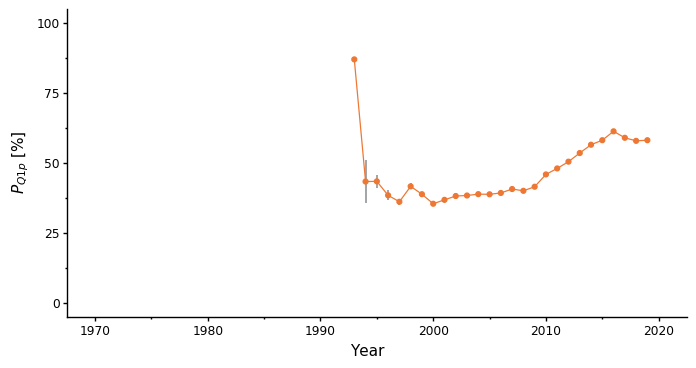

In [731]:
plot_q1_analysis(protein_q1_df, "Protein data without missing values", label="$P_{Q1p}$ [%]")

#### Proteins with imputed data

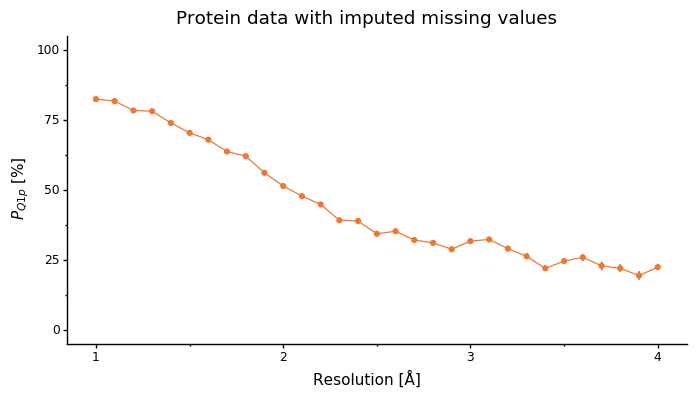

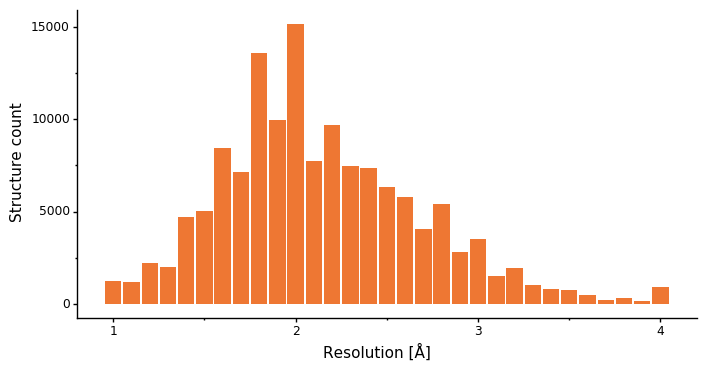

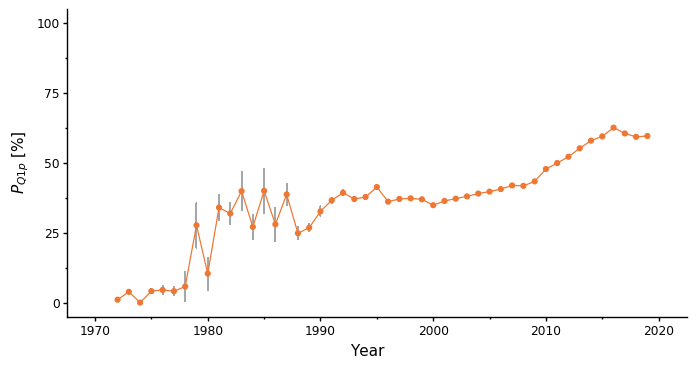

In [732]:
plot_q1_analysis(protein_imputed_q1_df, "Protein data with imputed missing values", label="$P_{Q1p}$ [%]")

#### Proteins with imputed data Q_min

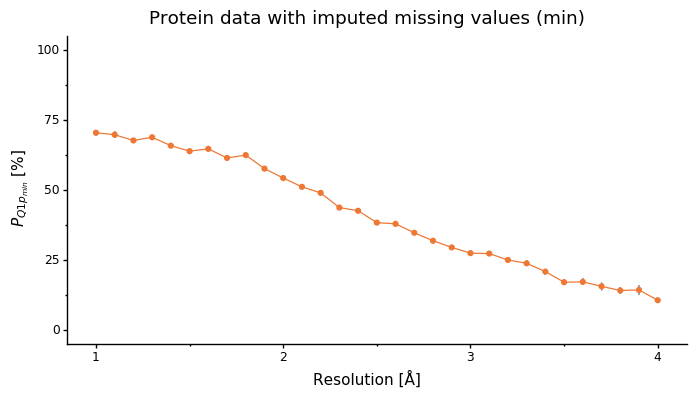

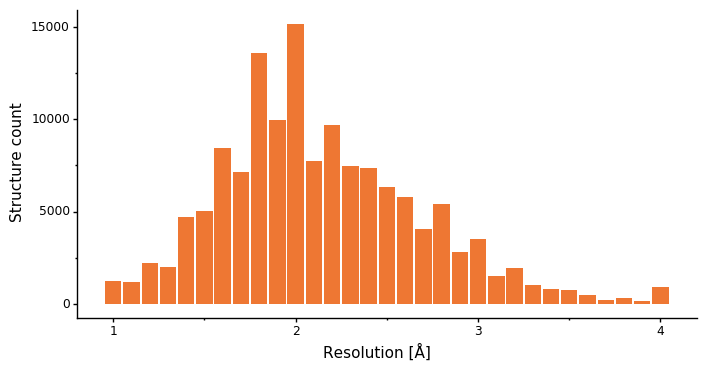

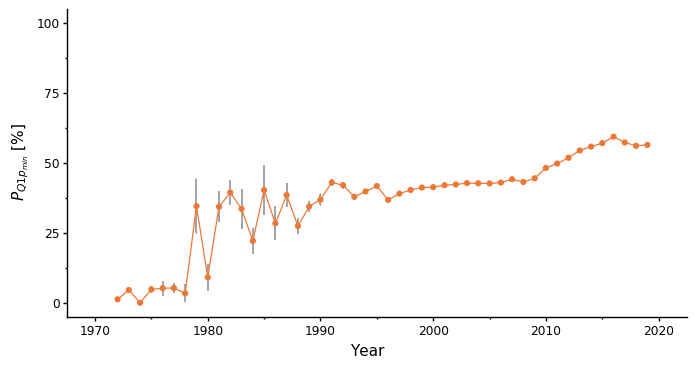

In [733]:
plot_q1_analysis(protein_imputed_q1_df, "Protein data with imputed missing values (min)", label="$P_{Q1p_{min}}$ [%]", percentile_col="Q1_min percentile")

#### Nucleic acids without data imputation

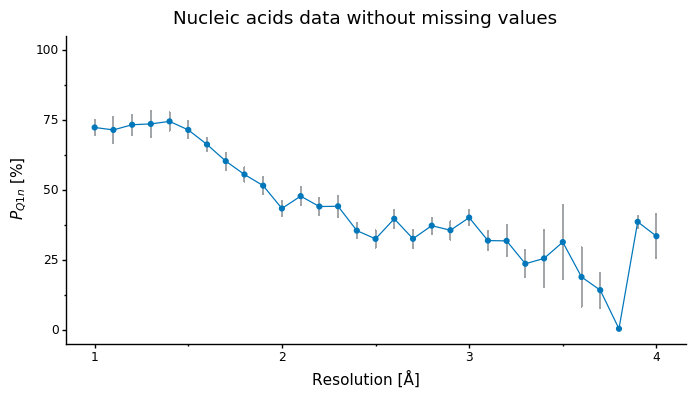

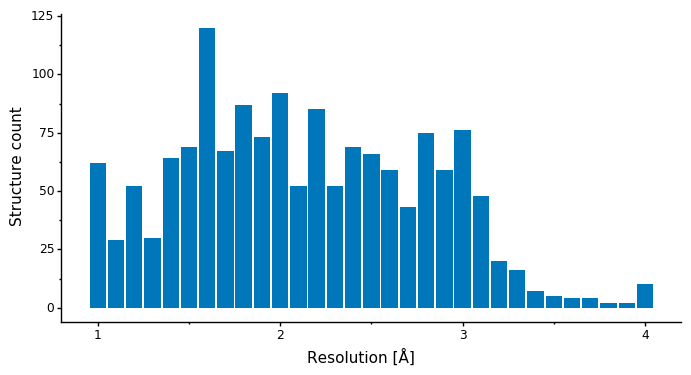

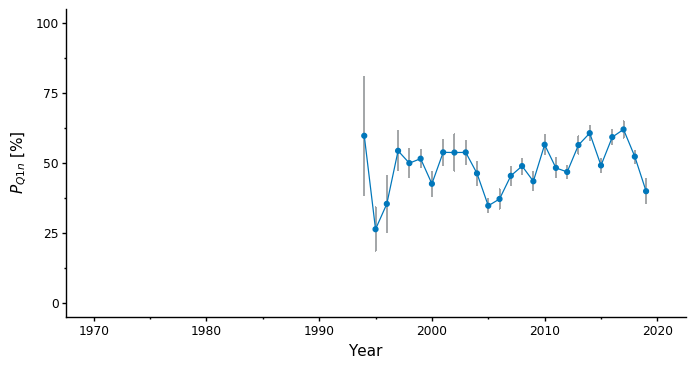

In [734]:
plot_q1_analysis(nucleic_q1_df, "Nucleic acids data without missing values", 
                 label="$P_{Q1n}$ [%]", color="#0077BB")

#### Nucleic acids with imputed data

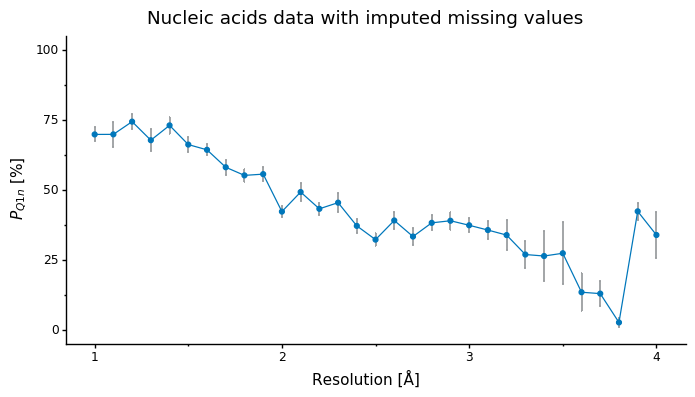

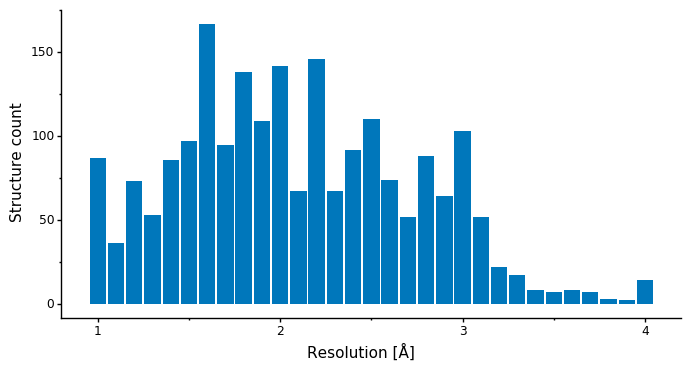

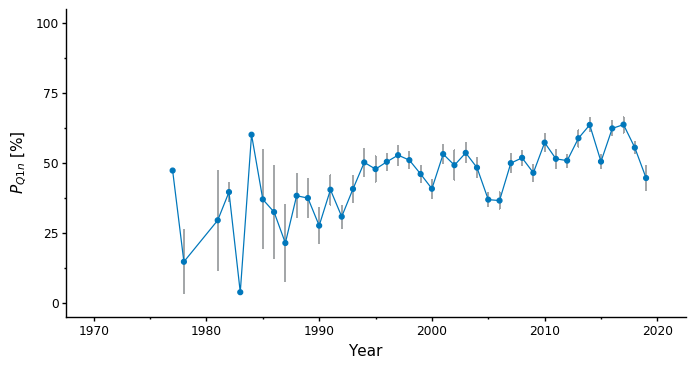

In [735]:
plot_q1_analysis(nucleic_imputed_q1_df, "Nucleic acids data with imputed missing values", 
                 label="$P_{Q1n}$ [%]", color="#0077BB")

#### Nucleic acids with imputed data Q_min

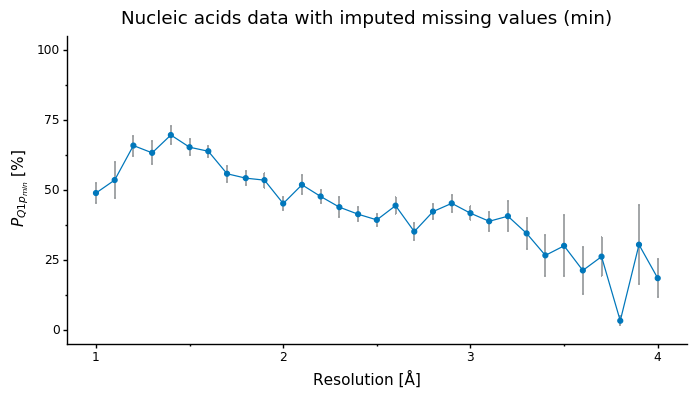

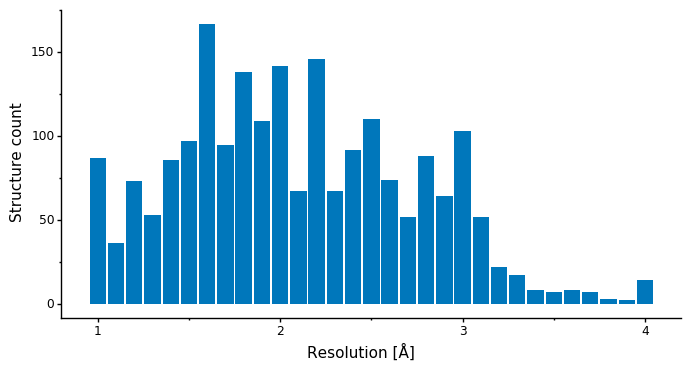

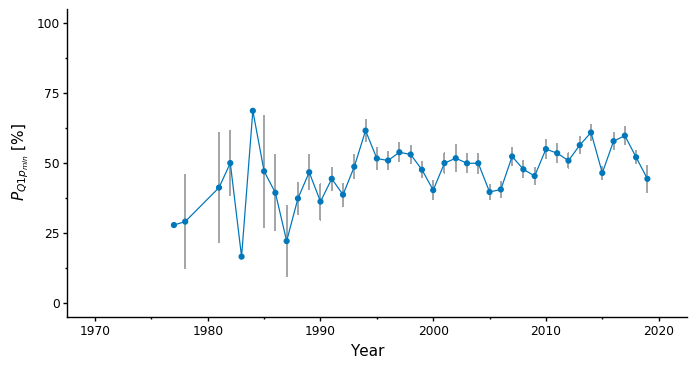

In [736]:
plot_q1_analysis(nucleic_imputed_q1_df, "Nucleic acids data with imputed missing values (min)", 
                 label="$P_{Q1p_{min}}$ [%]", percentile_col="Q1_min percentile",
                color="#0077BB")

### Q(t) and Q(td)

It can be noticed that there is a general trend of Q1 improving over the years. This is connected with the improvement of data collection procedures, hardware, software, and structure refinement standards. If one were to use Q1 calculated over all the analyzed years to rank journals, then journals with a longer history would be handicapped because they contain old structures. Even though a structure might have been impressively refined in its time, now it might be treated as a poorly refined structure according to current standards. One could recalculate Q1 percentiles separately for each decade or smaller time periods, but might not be sufficient (see the rapid improvement in the last 10 years) or would drastically reduce the data volume and effectively make journal comparison impossible. Therefore we propose to calculate Q1(t) --- the Q1 percentile calculated at time of structure deposition.

Moreover, seeing how strongly quality is related to resolution, we will perform two separate journal rankings: one using Q1(t) and one using Q1(t, r), i.e., the Q1 percentile calculated at time of structure deposition for a given resolution rounded to 1 decimal place and capped at 1 Å and 4 Å.

In [165]:
def add_Q1_t(q1_df):
    full_df = q1_df.sort_values(by=['Deposition date']).copy()
    full_df.loc[:, "Q1(t) percentile"] = full_df.loc[:, "Q1"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True)
    full_df.loc[:, "Q1_min(t) percentile"] = full_df.loc[:, "Q1_min"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True)
    
    return full_df

def add_Q1_tr(q1_df):
    full_df = q1_df.sort_values(by=['Deposition date']).copy()
    full_df.loc[:, "Resolution group"] = full_df.loc[:, "Resolution"].round(decimals=1)
    full_df.loc[full_df.loc[:, "Resolution group"] > 4, "Resolution group"] = 4.0
    full_df.loc[full_df.loc[:, "Resolution"] < 1, "Resolution"] = 1.0
    full_df.loc[:, "Q1(td) percentile"] = full_df.groupby('Resolution group')["Q1"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True).reset_index(level=0,drop=True)
    full_df.loc[:, "Q1_min(td) percentile"] = full_df.groupby('Resolution group')["Q1_min"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True).reset_index(level=0,drop=True)
    
    return full_df

protein_imputed_q1_df = add_Q1_t(protein_imputed_q1_df)
protein_imputed_q1_df = add_Q1_tr(protein_imputed_q1_df)

nucleic_imputed_q1_df = add_Q1_t(nucleic_imputed_q1_df)
nucleic_imputed_q1_df = add_Q1_tr(nucleic_imputed_q1_df)

In [166]:
journal_quality_imputed_df = protein_imputed_q1_df.append(nucleic_imputed_q1_df)
journal_quality_imputed_df.to_csv("results/journal_quality.csv")

In [167]:
journal_quality_imputed_df = pd.read_csv("results/journal_quality.csv")
describe(journal_quality_imputed_df)

,PDB code,Resolution,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],Year,Contains protein,R [%],R free [%],Deposition date,Journal,ISSN,Q1,Q1_min,Q1 percentile,Q1_min percentile,Q1(t) percentile,Q1_min(t) percentile,Resolution group,Q1(td) percentile,Q1_min(td) percentile
0,1sbt,2.50,95.46,10.730000,6.590000,5.794077,1972.000000,True,25.960733,31.663298,1972-08-11,BIOCHEM BIOPHYS RES COMMUN,0006-291X,0.080332,0.004847,0.011922,0.013134,1.000000,1.000000,2.500000,1.000000,1.000000
1,1mbn,2.00,54.11,15.200000,3.310000,4.781674,1973.000000,True,22.109731,28.254517,1973-04-05,PROG STEREOCHEM,0079-6808,0.139395,0.015474,0.039894,0.040937,1.000000,1.000000,2.000000,1.000000,1.000000
2,2dhb,2.80,26.21,15.090000,5.650000,4.279127,1973.000000,True,23.245285,29.884926,1973-11-01,NATURE,0028-0836,0.139332,0.019969,0.039837,0.052305,0.666667,1.000000,2.800000,1.000000,1.000000
3,3ldh,3.00,189.76,39.860000,14.630000,9.071444,1974.000000,True,32.423844,40.723698,1974-06-06,J MOL BIOL,0022-2836,0.027349,0.000352,0.001488,0.001021,0.250000,0.250000,3.000000,1.000000,1.000000
4,2cha,2.00,23.29,16.670000,1.730000,3.979372,1975.000000,True,20.410695,26.850902,1975-01-01,J MOL BIOL,0022-2836,0.204080,0.040340,0.089143,0.102259,1.000000,1.000000,2.000000,1.000000,1.000000


Dataset rows: 141154
Dataset columns: 22


#### Proteins vs nucleic acids

The calculation of Q1(t,d) provides a unique chance of comparing the average quality of protein and nucleic acid models over time. Below a plot that shows how the average quality of these two groups of molecules changed over time. For many years in the past, newly deposited nucleic acid models were usually of better quality than newly deposited protein models, especially between 1993 and 2004. However, the steady improvement of the quality of protein models in the last decade has made them currently to be on a par, if not better, than currently deposited nucleic acids models.

In [719]:
def plot_comparison(df, title, percentile_col="Q1 percentile", label="$P_{Q1}$ [%]"):
    plot_df = df.copy()
    plot_df = plot_df.rename(columns={percentile_col: percentile_col.replace(" ", "_").replace("(", "_").replace(")", "_")})
    percentile_col = percentile_col.replace(" ", "_").replace("(", "_").replace(")", "_")
    
    plot_df.loc[:, "Resolution"] = plot_df.loc[:, "Resolution"].round(decimals=1)
    plot_df.loc[:, percentile_col] = plot_df.loc[:, percentile_col] * 100
    plot_df.loc[plot_df.loc[:, "Resolution"] > 4, "Resolution"] = 4
    plot_df.loc[plot_df.loc[:, "Resolution"] < 1, "Resolution"] = 1
    plot_df.loc[:, "Macromolecules"] = "Nucleic acids"
    plot_df.loc[plot_df.loc[:, "Contains protein"], "Macromolecules"] = "Proteins"
    display(plot_df.groupby(["Macromolecules"], as_index=False).mean().drop(
        ["Year", "Contains protein", "Q1", "Resolution group"], axis=1))
    
    year_df = plot_df.groupby(["Macromolecules", 'Year'], as_index=False).mean()
    year_df_sem = plot_df.loc[:, ["Macromolecules", 'Year', percentile_col]].groupby(["Macromolecules", 'Year']).sem()
    year_df_sem = year_df_sem.rename(columns={percentile_col: "sem"})
    year_df = year_df.merge(year_df_sem, left_on=["Macromolecules", 'Year'], right_index=True)
     
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = (ggplot(year_df, aes(x="Year", y=percentile_col, color="Macromolecules")) +
             geom_errorbar(width=0.01, size=0.75, mapping=aes(x="Year", ymin=percentile_col+"-sem",
                           ymax=percentile_col+"+sem"), color="#9DA0A2") +
             geom_line() + 
             geom_point() +
             xlim(1970, 2020) + ylim(0, 100) + ylab(label) + theme_classic() +
             scale_color_manual(values = ["#0077BB", "#EE7733"]) +
             theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black")))
        p.save("results/images/" + title + "_year.svg")
        p.save("results/images/" + title + "_year.pdf")
        p.draw();
   

,Macromolecules,Resolution,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],R [%],R free [%],Q1_min,Q1 percentile,Q1_min percentile,Q1(t) percentile,Q1_min(t) percentile,Q1_td__percentile,Q1_min(td) percentile
0,Nucleic acids,2.095925,13.068011,NaN,NaN,2.262777,20.495013,24.454800,0.297592,0.500240,0.500240,0.553277,0.527710,59.909191,0.572845
1,Proteins,2.136964,8.843004,3.660323,0.575251,4.012600,19.390684,23.512717,0.301201,0.500004,0.500004,0.578315,0.557155,58.677457,0.571741


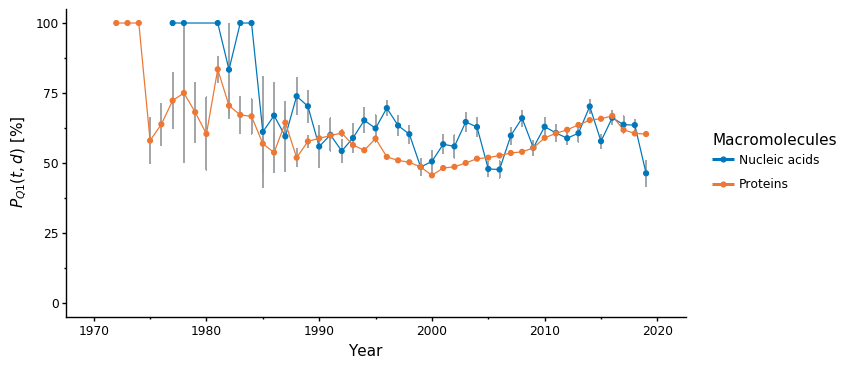

In [720]:
plot_comparison(journal_quality_imputed_df, "macromolecule type comparison", "Q1(td) percentile", label="$P_{Q1}(t,d)$ [%]")

,Macromolecules,Resolution,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],R [%],R free [%],Q1_min,Q1 percentile,Q1_min percentile,Q1(t) percentile,Q1_min(t) percentile,Q1(td) percentile,Q1_min_td__percentile
0,Nucleic acids,2.095925,13.068011,NaN,NaN,2.262777,20.495013,24.454800,0.297592,0.500240,0.500240,0.553277,0.527710,0.599092,57.284506
1,Proteins,2.136964,8.843004,3.660323,0.575251,4.012600,19.390684,23.512717,0.301201,0.500004,0.500004,0.578315,0.557155,0.586775,57.174076


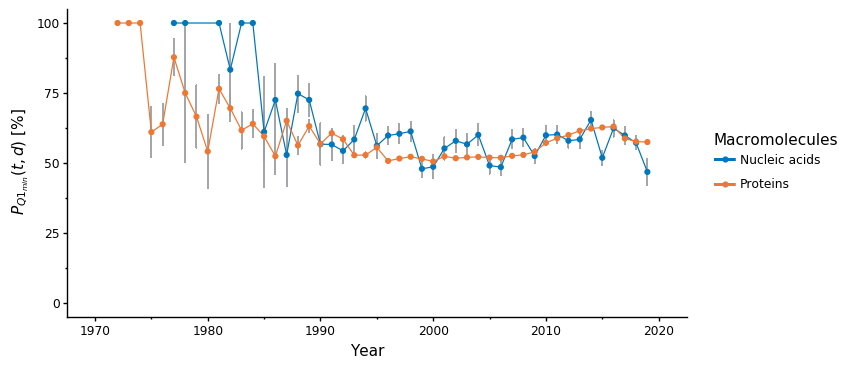

In [721]:
plot_comparison(journal_quality_imputed_df, "macromolecule type comparison", "Q1_min(td) percentile", label="$P_{Q1_{min}}(t,d)$ [%]")

In [722]:
MIN_STRUCTURES_IN_JOURNAL = 100
PERCENTILE_OFFSET = 0

ranking_df = journal_quality_imputed_df.iloc[PERCENTILE_OFFSET:, :].copy()
venue_count_df = ranking_df.groupby(['Journal'], as_index=False).size()
venue_count_df = venue_count_df.rename("Structure count")
venue_count_df = venue_count_df.sort_values(ascending=False)
popular_venues = venue_count_df[venue_count_df >= MIN_STRUCTURES_IN_JOURNAL].index
ranking_df = ranking_df.loc[ranking_df.Journal.isin(popular_venues), :]

### Journal ranking according to Q(t)

The ranking includes journals which published at least 100 structures.

In [725]:
def perform_t_tests(df, measure, p_threshold=0.001, correction=True):
    population = df.loc[:, measure].values
    test_results_df = pd.DataFrame({"Journal": [], "p-value": []})
    
    if correction:
        p_threshold = p_threshold / df.Journal.unique().shape[0]
    
    for journal in df.Journal.unique():
        welch = ss.ttest_ind(population, 
                             df.loc[ranking_df.Journal == journal, measure],
                             equal_var=False, 
                             nan_policy='raise')
        test_results_df = test_results_df.append(pd.DataFrame({"Journal": [journal], "p-value": [welch[1]]}))
        
    test_results_df.loc[:, "Significant"] = test_results_df.loc[:, "p-value"] < p_threshold
    test_results_df = test_results_df.set_index("Journal")
    
    return test_results_df.sort_values("p-value")


def vmean(x):
    return np.power(np.mean(np.power(x, -1/3.0)), -3.0)


def display_ranking(df, measure, venue_count_df, suffix=""):
    ranking_df = df.copy()
    ranking_df.loc[:, "log(Resolution)"] = ranking_df.loc[:, "Resolution"]
    tests_df = perform_t_tests(ranking_df, measure)
    std_df = ranking_df.loc[:, ["Journal", measure]].groupby(['Journal']).std()
    std_df.loc[:, "Std"] = std_df.loc[:, measure]
    std_df = std_df.drop(measure, axis=1)
    gmean_df = ranking_df.loc[:, ["Journal", "Resolution"]].groupby(['Journal']).apply(ss.gmean).apply(lambda x: x[0])
    gmean_df = gmean_df.rename("G-mean resolution")
    vmean_df = ranking_df.loc[:, ["Journal", "Resolution"]].groupby(['Journal']).apply(vmean).Resolution
    vmean_df = vmean_df.rename("V-mean resolution")
    
    venue_df = ranking_df.groupby(['Journal'], as_index=False).mean()
    venue_df = pd.merge(venue_df, gmean_df, right_index=True, left_on="Journal")
    venue_df = pd.merge(venue_df, vmean_df, right_index=True, left_on="Journal")
    venue_df = pd.merge(venue_df, std_df, right_index=True, left_on="Journal")
    venue_df = pd.merge(venue_df, tests_df, right_index=True, left_on="Journal")
    venue_df = pd.merge(venue_df, venue_count_df, right_index=True, left_on="Journal")
    
    measure_ranking_df = venue_df.sort_values(by=measure, ascending=False).loc[:, ["Journal", "Significant", measure, "Std", "Resolution", "G-mean resolution", "V-mean resolution", "Structure count"]]
    measure_ranking_df.insert(loc=0, column='Rank', value=(np.arange(len(measure_ranking_df)) + 1))
    measure_ranking_df = measure_ranking_df.set_index('Rank')
    measure_ranking_df = measure_ranking_df.rename(columns={"Resolution": "A-mean resolution"})
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(measure_ranking_df)
        
    measure_ranking_df.loc[measure_ranking_df.Significant, "Journal"] = measure_ranking_df.loc[measure_ranking_df.Significant, "Journal"] + "*"
    measure_ranking_df.loc[:, measure] = measure_ranking_df.loc[:, measure] * 100
    measure_ranking_df = measure_ranking_df.drop(["Significant", "Std"], axis=1)
    measure_ranking_df.to_csv("results/ranking " + measure + str(suffix) + ".csv")
        

In [727]:
display_ranking(ranking_df, "Q1(t) percentile", venue_count_df)

,Journal,Significant,Q1(t) percentile,Std,A-mean resolution,G-mean resolution,V-mean resolution,Structure count
Rank,,,,,,,,
1,TUBERCULOSIS (EDINB),True,0.848033,0.174538,2.020318,1.995428,1.987031,132
2,CHEMISTRY,True,0.723390,0.237088,1.820430,1.765553,1.747676,242
3,CHEM COMMUN,True,0.718774,0.256523,1.805000,1.745772,1.726895,280
4,CHEMBIOCHEM,True,0.718392,0.247558,1.920974,1.866985,1.849146,527
5,ACS INFECT DIS,True,0.716906,0.224977,1.946895,1.904006,1.889870,153
6,EUR J MED CHEM,True,0.713911,0.238777,2.027804,1.972115,1.953496,418
7,ACS CATAL,True,0.713334,0.262270,1.936618,1.875695,1.855433,241
8,ORG BIOMOL CHEM,True,0.712127,0.251830,1.882624,1.824194,1.804377,167
9,J INORG BIOCHEM,True,0.711069,0.243961,1.784438,1.728283,1.709718,171


### Journal ranking according to Q_min(t)

In [728]:
display_ranking(ranking_df, "Q1_min(t) percentile", venue_count_df)

,Journal,Significant,Q1_min(t) percentile,Std,A-mean resolution,G-mean resolution,V-mean resolution,Structure count
Rank,,,,,,,,
1,TUBERCULOSIS (EDINB),True,0.819331,0.191120,2.020318,1.995428,1.987031,132
2,ORG BIOMOL CHEM,True,0.703604,0.246412,1.882624,1.824194,1.804377,167
3,CHEM COMMUN,True,0.700562,0.270302,1.805000,1.745772,1.726895,280
4,CHEMBIOCHEM,True,0.697945,0.259393,1.920974,1.866985,1.849146,527
5,ACS CATAL,True,0.695620,0.270536,1.936618,1.875695,1.855433,241
6,EUR J MED CHEM,True,0.681082,0.251750,2.027804,1.972115,1.953496,418
7,ACS INFECT DIS,True,0.679219,0.259976,1.946895,1.904006,1.889870,153
8,J INORG BIOCHEM,True,0.676728,0.263987,1.784438,1.728283,1.709718,171
9,J BIOL INORG CHEM,True,0.672274,0.279620,1.884088,1.821753,1.801113,265


### Journal ranking according to Q(td)

The ranking includes journals that published at least 100 structures.

In [729]:
display_ranking(ranking_df, "Q1(td) percentile", venue_count_df)

,Journal,Significant,Q1(td) percentile,Std,A-mean resolution,G-mean resolution,V-mean resolution,Structure count
Rank,,,,,,,,
1,TUBERCULOSIS (EDINB),True,0.873823,0.149521,2.020318,1.995428,1.987031,132
2,EUR J MED CHEM,True,0.710443,0.248660,2.027804,1.972115,1.953496,418
3,ACS CATAL,True,0.692523,0.266136,1.936618,1.875695,1.855433,241
4,ACS INFECT DIS,True,0.683196,0.243137,1.946895,1.904006,1.889870,153
5,CHEMBIOCHEM,True,0.682976,0.262175,1.920974,1.866985,1.849146,527
6,IUCRJ,True,0.677580,0.265927,1.953102,1.882433,1.859550,281
7,ORG BIOMOL CHEM,False,0.674130,0.261865,1.882624,1.824194,1.804377,167
8,MBIO,False,0.667234,0.257721,2.238676,2.154123,2.126184,169
9,ARCH BIOCHEM BIOPHYS,True,0.661312,0.271452,2.079391,2.032895,2.017176,276


### Journal ranking according to Q_min(t)

In [730]:
display_ranking(ranking_df, "Q1_min(td) percentile", venue_count_df)

,Journal,Significant,Q1_min(td) percentile,Std,A-mean resolution,G-mean resolution,V-mean resolution,Structure count
Rank,,,,,,,,
1,TUBERCULOSIS (EDINB),True,0.822001,0.204358,2.020318,1.995428,1.987031,132
2,CELL HOST MICROBE,False,0.678356,0.246549,2.496346,2.427730,2.404116,107
3,EUR J MED CHEM,True,0.673246,0.268640,2.027804,1.972115,1.953496,418
4,ACS CATAL,True,0.671181,0.279689,1.936618,1.875695,1.855433,241
5,ORG BIOMOL CHEM,False,0.662057,0.268374,1.882624,1.824194,1.804377,167
6,CHEMBIOCHEM,True,0.660203,0.274366,1.920974,1.866985,1.849146,527
7,ACS INFECT DIS,False,0.642352,0.286018,1.946895,1.904006,1.889870,153
8,ARCH BIOCHEM BIOPHYS,False,0.641422,0.272770,2.079391,2.032895,2.017176,276
9,CHEM COMMUN,False,0.639196,0.278669,1.805000,1.745772,1.726895,280


### Journal impact and structure quality correlation

To measure journal impact, we have used two metrics:

- IPP (Impact Per Paper)
- SNIP (Source Normalized Impact per Paper)

based on Scopus data and publicly available through [CWTS](https://www.journalindicators.com/). IPP resembles 3-year impact factor, whereas SNIP additionally takes into account scientific field citability. Both used metrics are publicly available and based on the same (Scopus) source data. At the same time, each metric offers a slightly different definition of impact.

In [488]:
# # to reproduce the journal metric dataset, download source data files 
# # from CWTS and SCImago and use the code below
# ######################################################################

cwts_df = pd.read_excel("data/sources/CWTS Journal Indicators May 2019.xlsx")
cwts_df = cwts_df.loc[:, ["Source title", "Print ISSN", "Electronic ISSN", "Year", "IPP", "SNIP"]]
cwts_df = cwts_df.loc[(cwts_df.loc[:, "Print ISSN"].isin(full_quality_df.ISSN)) | (cwts_df.loc[:, "Electronic ISSN"].isin(full_quality_df.ISSN)), :]
cwts_df.to_csv("data/journal_metrics.csv", index=False)

In [489]:
journal_metrics_df = pd.read_csv("data/journal_metrics.csv")

ranking_for_year = ranking_df.groupby(["Year", "Journal", "ISSN"], as_index=False).mean()
r_issn_1 = ranking_for_year.merge(journal_metrics_df, left_on=["Year", "ISSN"], right_on=["Year", "Print ISSN"], how="inner")
r_issn_2 = ranking_for_year.merge(journal_metrics_df, left_on=["Year", "ISSN"], right_on=["Year", "Electronic ISSN"], how="inner")
ranking_for_year = pd.concat([r_issn_1, r_issn_2])
ranking_for_year.loc[:, "Q1(td) percentile"] = ranking_for_year.loc[:, "Q1(td) percentile"] * 100

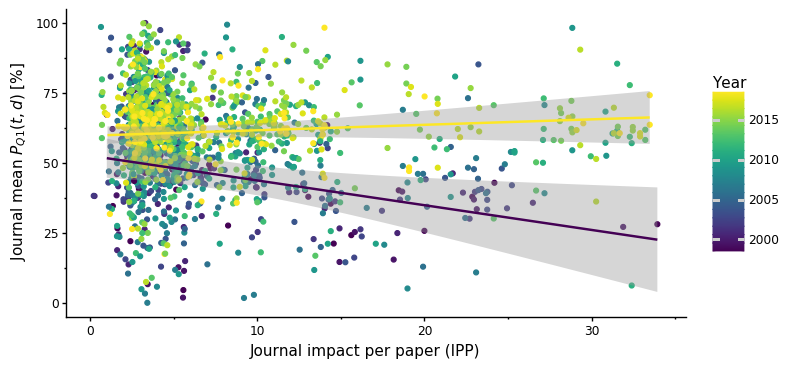

In [723]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p = (ggplot(ranking_for_year, aes(x="IPP", y="Q1(td) percentile", color="Year")) + 
     geom_point() +
     geom_smooth(data=ranking_for_year.loc[ranking_for_year.Year == 1999.0, :], method="lm") +
     geom_smooth(data=ranking_for_year.loc[ranking_for_year.Year == 2018.0, :], method="lm") +
     theme_classic() +
     ylim(0,100) +
     ylab("Journal mean $P_{Q1}(t,d)$ [%]") + 
     xlab("Journal impact per paper (IPP)") + 
     scale_color_cmap("viridis") +
     theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black"))
    )
    p.save("results/images/journal_impact_vs_quality.svg")
    p.save("results/images/journal_impact_vs_quality.pdf")
    p.draw();

In [724]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p = (ggplot(ranking_for_year, aes(x="IPP", y="Q1(td) percentile", color="Year")) + 
     geom_point() +
     geom_smooth(data=ranking_for_year.loc[ranking_for_year.Year == 1999.0, :], method="lm") +
     geom_smooth(data=ranking_for_year.loc[ranking_for_year.Year == 2018.0, :], method="lm") +
     theme_classic() +
     ylim(0,100) +
     ylab("PDB structure quality percentile [%]") + 
     xlab("Journal 3-year impact factor") +
     scale_color_cmap("viridis") +
     theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black"))
    )
    p.save("results/images/ga.pdf", units="mm", width=140, height=140, dpi=300)
#     p.draw();

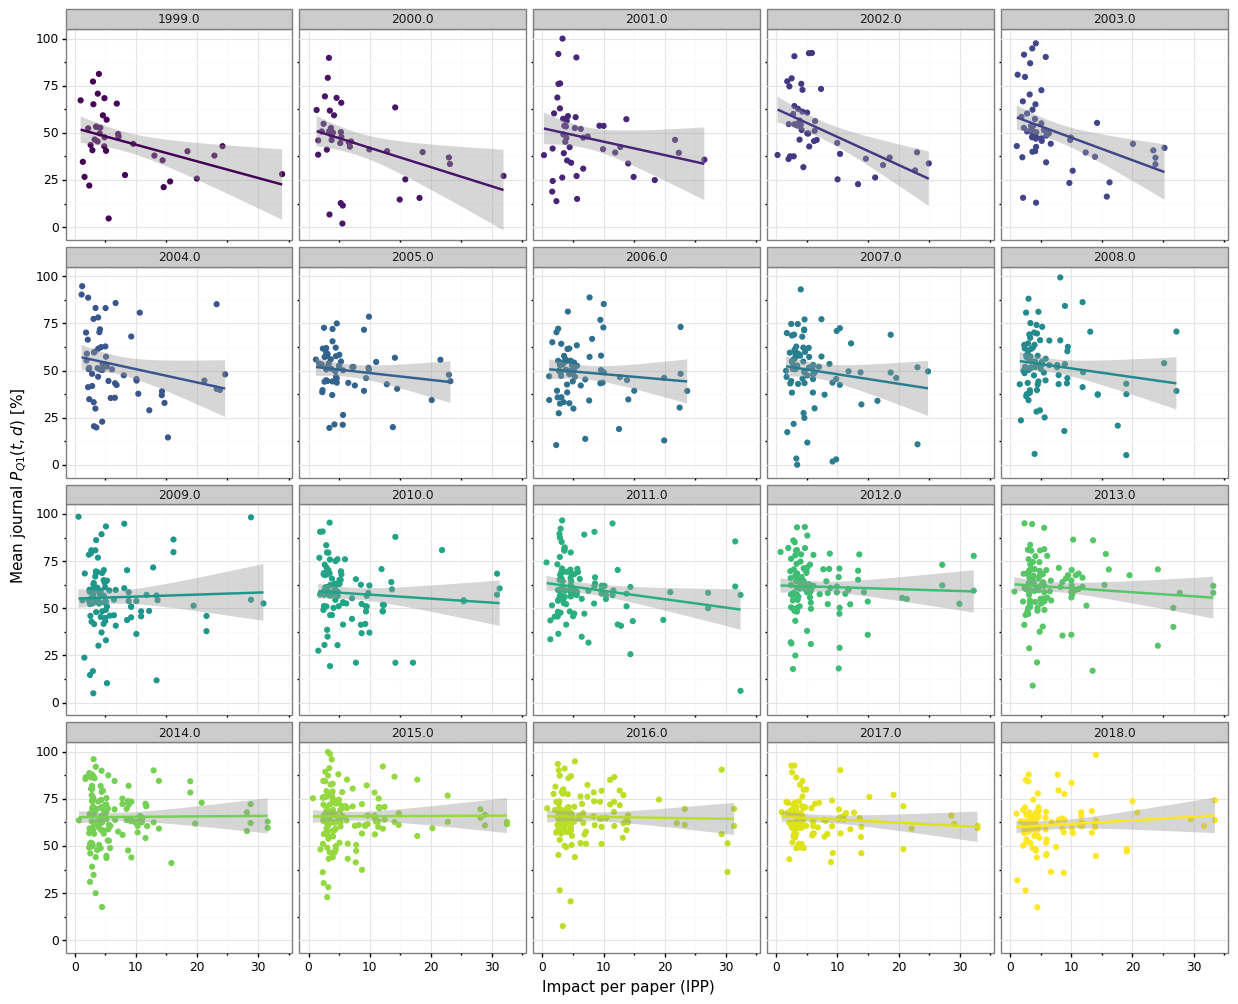

In [549]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p = (ggplot(ranking_for_year, aes(x="IPP", y="Q1(td) percentile", color="Year")) + 
     geom_point() +
     facet_wrap('~Year', ncol=5) + 
     geom_smooth(method="lm") +
     theme_bw() +
     xlab("Impact per paper (IPP)") +
     ylab("Mean journal $P_{Q1}(t,d)$ [%]") + 
     theme(legend_position = "none", figure_size=(15, 12), 
          axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black"))
    )
    p.save("results/images/journal_impact_vs_quality_years.svg")
    p.save("results/images/journal_impact_vs_quality_years.pdf")
    p.draw();
        

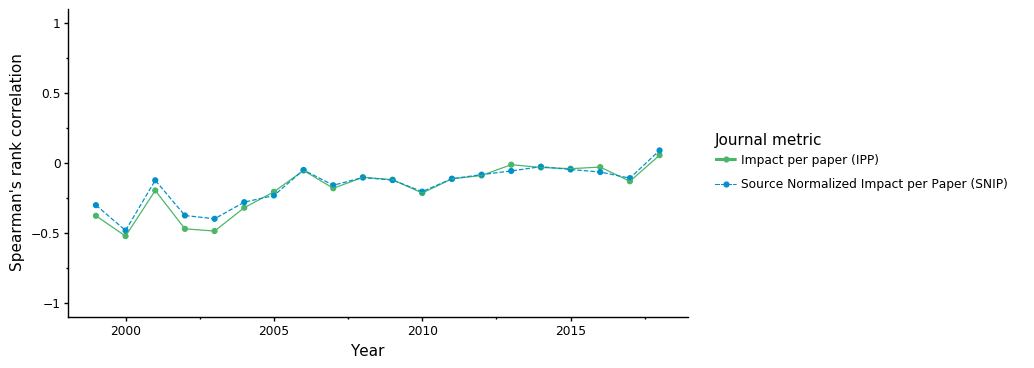

In [743]:
from scipy.stats import pearsonr, spearmanr
plot_years = []
plot_methods = []
plot_correlations = []
plot_metrics = []


for y in range(20):
    year = y+1999

    plot_years.append(year)
    plot_metrics.append("Impact per paper (IPP)")
    plot_correlations.append(spearmanr(ranking_for_year.loc[ranking_for_year.Year == year, "IPP"], 
             ranking_for_year.loc[ranking_for_year.Year == year, "Q1(td) percentile"])[0])
    
    plot_years.append(year)
    plot_metrics.append("Source Normalized Impact per Paper (SNIP)")
    plot_correlations.append(spearmanr(ranking_for_year.loc[ranking_for_year.Year == year, "SNIP"], 
             ranking_for_year.loc[ranking_for_year.Year == year, "Q1(td) percentile"])[0])

    6.06016615279205

correlations_df = pd.DataFrame({"Year": plot_years, "Correlation": plot_correlations, "Metric": plot_metrics})

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p = (ggplot(correlations_df, aes(x="Year", y="Correlation", color="Metric", linetype="Metric")) + 
         geom_point() +
         geom_line() +
         theme_classic() +
         ylim(-1,1) +
         ylab("Spearman's rank correlation") + labs(color = "Journal metric", linetype = "Journal metric") +
         scale_color_manual(values = ["#4AB668", "#0091CC"]) + 
         theme(axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black"))
    )
    p.save("results/images/impact_quality_correlation_over_time.svg")
    p.save("results/images/impact_quality_correlation_over_time.pdf")
#     p = p + labs(title="Impact-quality correlation over time")
    p.draw();

## Rankings over time

For readability, bump charts presenting rankings over time present only the all-time 25 most popular journals (i.e., the journals with most structures), which published at least 30 structures since 2015.

In [495]:
MIN_STRUCTURES_IN_RANGE = 30

ranking_last5_years_df = journal_quality_imputed_df.iloc[PERCENTILE_OFFSET:, :].copy()
ranking_last5_years_df = ranking_last5_years_df.loc[ranking_last5_years_df.Year > 2015, :]
venue_count_recent_df = ranking_last5_years_df.groupby(['Journal'], as_index=False).size()
venue_count_recent_df = venue_count_recent_df.rename("Structure count")
venue_count_recent_df = venue_count_recent_df.loc[venue_count_recent_df >= MIN_STRUCTURES_IN_RANGE]
chart_eligible_venues = venue_count_recent_df.index

top25_venues = venue_count_df.loc[venue_count_df.index.isin(chart_eligible_venues)].iloc[:25].index
ranking_of_25_most_popular_df = ranking_df.loc[ranking_df.Journal.isin(top25_venues), :]

In [497]:
def plot_rankings(ranking_df, measure, label):
    venue_df = ranking_df.groupby(['Journal'], as_index=False).mean()
    venue_df = pd.merge(venue_df, venue_count_df, right_index=True, left_on="Journal")
        
    year_venue_df = ranking_of_25_most_popular_df.groupby(['Year', 'Journal'], as_index=False).mean()
    year_venue_df.loc[:, measure] = year_venue_df.loc[:, measure]*100
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = (ggplot(year_venue_df, aes(x="Year", y=measure)) + 
         geom_point(color="#777777") +
         facet_wrap('~Journal', ncol=5) + 
         geom_smooth() +
         ylim(0,100) + 
         ylab(label) + 
         theme_bw() +
         theme(legend_position = "none", figure_size=(15, 15), 
              axis_text_x=element_text(colour="black"), axis_text_y=element_text(colour="black"))
        )
        p.save("results/images/" + measure + "_journals_over_time.svg")
        p.save("results/images/" + measure + "_journals_over_time.pdf")
        p = p + labs(title="Quality of popular journals over time [" + measure + "]")
        p.draw();
        
    measure_ranking_df = venue_df.sort_values(by=measure, ascending=False).loc[:, ["Journal", measure, "Structure count"]]
    measure_ranking_df.insert(loc=0, column='Rank', value=(np.arange(len(measure_ranking_df)) + 1))
    measure_ranking_df = measure_ranking_df.set_index('Rank')
    measure_ranking_df.to_csv("results/ranking " + measure + ".csv")

    TOP_N = 25
    COLORED_JOURNALS = ["STRUCTURE", "SCIENCE", "NATURE", "FEBS J", "PROTEINS", "NUCLEIC ACIDS RES", "TO BE PUBLISHED", "CELL"]

    year_venue_df_over_time = ranking_of_25_most_popular_df.copy()
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year <= 1990), "Year"] = 1990
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 1990) & (year_venue_df_over_time.Year <= 1995), "Year"] = 1995
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 1995) & (year_venue_df_over_time.Year <= 2000), "Year"] = 2000
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2000) & (year_venue_df_over_time.Year <= 2005), "Year"] = 2005
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2005) & (year_venue_df_over_time.Year <= 2010), "Year"] = 2010
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2010) & (year_venue_df_over_time.Year <= 2015), "Year"] = 2015
    year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2015), "Year"] = 2020

    year_venue_counts = year_venue_df_over_time.groupby(['Year', 'Journal'], as_index=False).size().copy()
    venue_count_filter = (year_venue_counts >= MIN_STRUCTURES_IN_RANGE).values
    
    year_venue_df_over_time = year_venue_df_over_time.groupby(['Year', 'Journal'], as_index=False).mean().copy()   
    year_venue_df_over_time = year_venue_df_over_time.loc[venue_count_filter, :]
    year_venue_df_over_time.loc[:, "Rank"] = year_venue_df_over_time.groupby(['Year'])[measure].rank(ascending=False)
    year_venue_df_over_time.loc[:, "Journal color"] = "zzz"
    year_venue_df_over_time.loc[year_venue_df_over_time.Journal.isin(COLORED_JOURNALS), "Journal color"] = year_venue_df_over_time.loc[year_venue_df_over_time.Journal.isin(COLORED_JOURNALS), "Journal"] 

    journal_colors = ["#0077BB","#0099BB","#EE7733","#CC3311", "#EE3377", "#DDAA33", "#007733", "#000000", "#CCCCCC"]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = (ggplot(year_venue_df_over_time, aes(x = "Year", y = "Rank", group = "Journal")) +
         geom_line(aes(color = "Journal color", alpha = 0.5), size = 1.75) +
         geom_point(aes(color = "Journal color", alpha = 0.5), size = 4) +
         geom_point(color = "#FFFFFF", size = 1) +
         scale_y_reverse(breaks = range(5, TOP_N + 1), minor_breaks = range(1, TOP_N + 1)) +
         scale_x_continuous(breaks = range(1990, 2025, 5), minor_breaks = range(1983, 2031, 1),
                           labels=[u"≤ 1990", "1991-1995", "1996-2000", "2001-2005", 
                                   "2006-2010", "2011-2015", "≥ 2016"]) +
         geom_text(year_venue_df_over_time.loc[year_venue_df_over_time.Year == year_venue_df_over_time.Year.min(), :],
                   aes(label = "Journal", x = year_venue_df_over_time.Year.min()-1, color = "Journal color"), ha="right", size = 7) +
         geom_text(year_venue_df_over_time.loc[year_venue_df_over_time.Year == year_venue_df_over_time.Year.max(), :],
                   aes(label = "Journal", x = year_venue_df_over_time.Year.max()+1, color = "Journal color"), ha="left", size = 7) +
         ylim(TOP_N, 1) + 
         theme_minimal() + 
         theme(legend_position = "none", panel_grid_minor = element_blank(),
               axis_text_x=element_text(colour="black", size=8), axis_text_y=element_text(colour="black")) +
         scale_color_manual(values = journal_colors)
        )
        p.save("results/images/" + measure + "_ranking_over_time.svg")
        p.save("results/images/" + measure + "_ranking_over_time.pdf")
        p = p + labs(title = "Ranking of popular journals over time [" + measure + "]")
        p.draw();

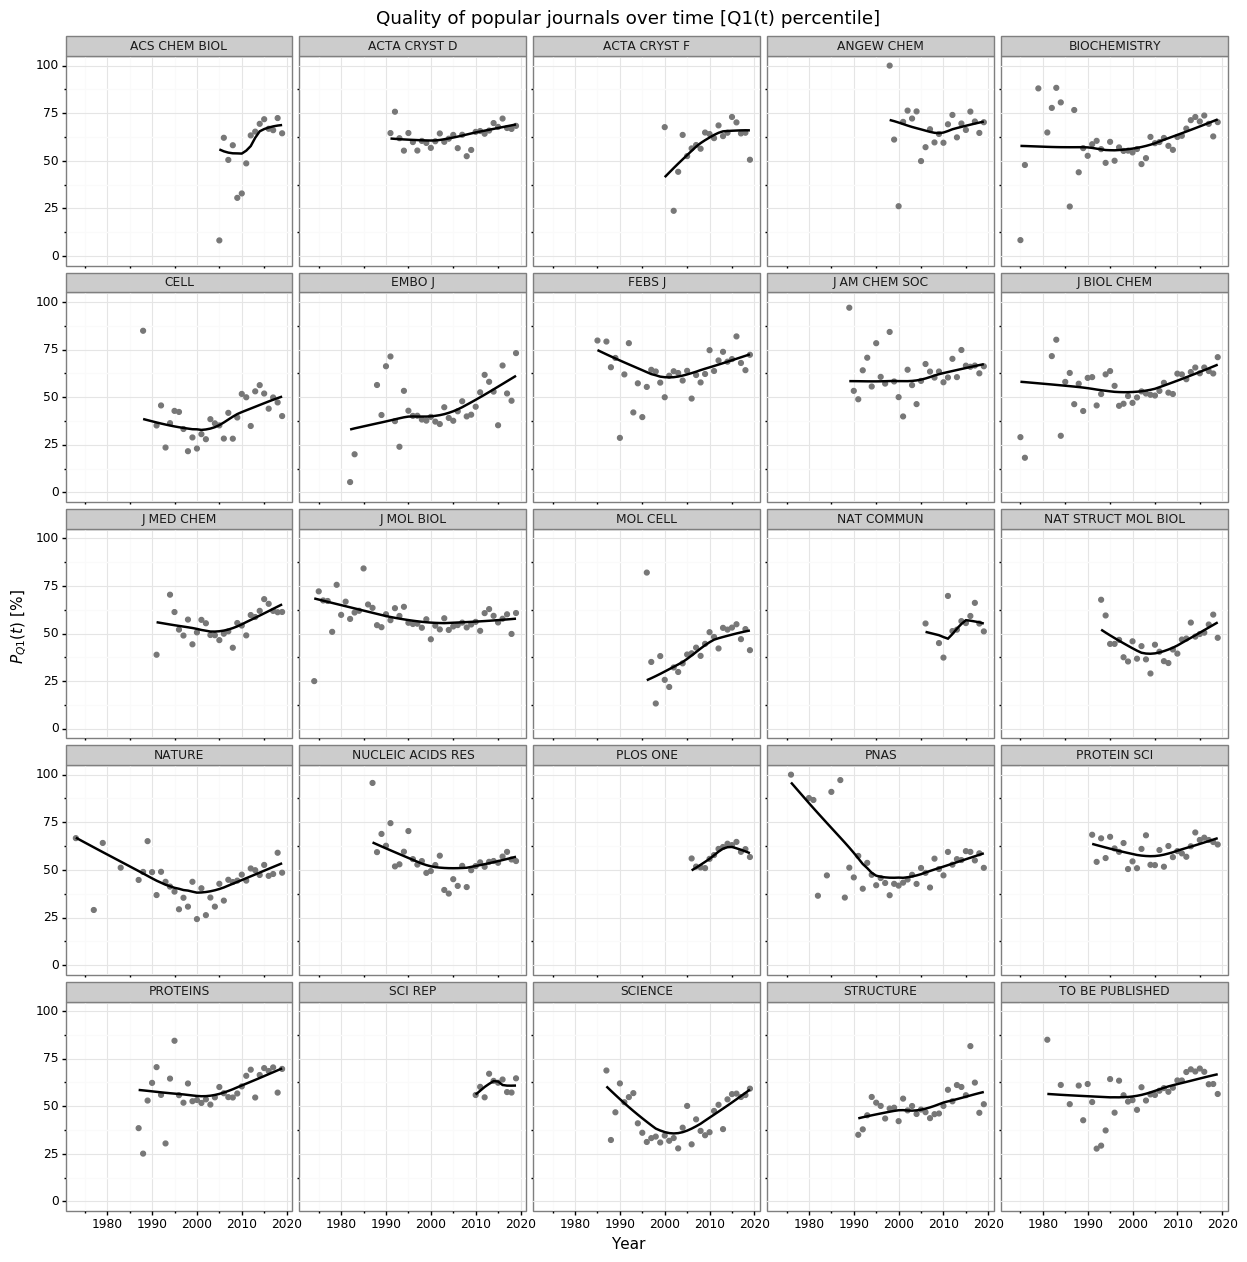

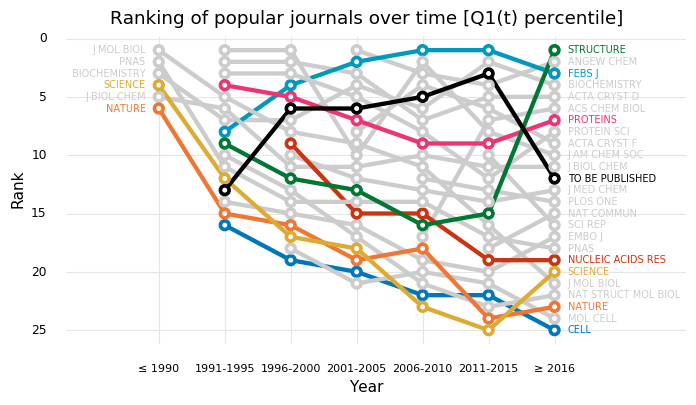

In [498]:
plot_rankings(ranking_df, "Q1(t) percentile", label="$P_{Q1}(t)$ [%]")

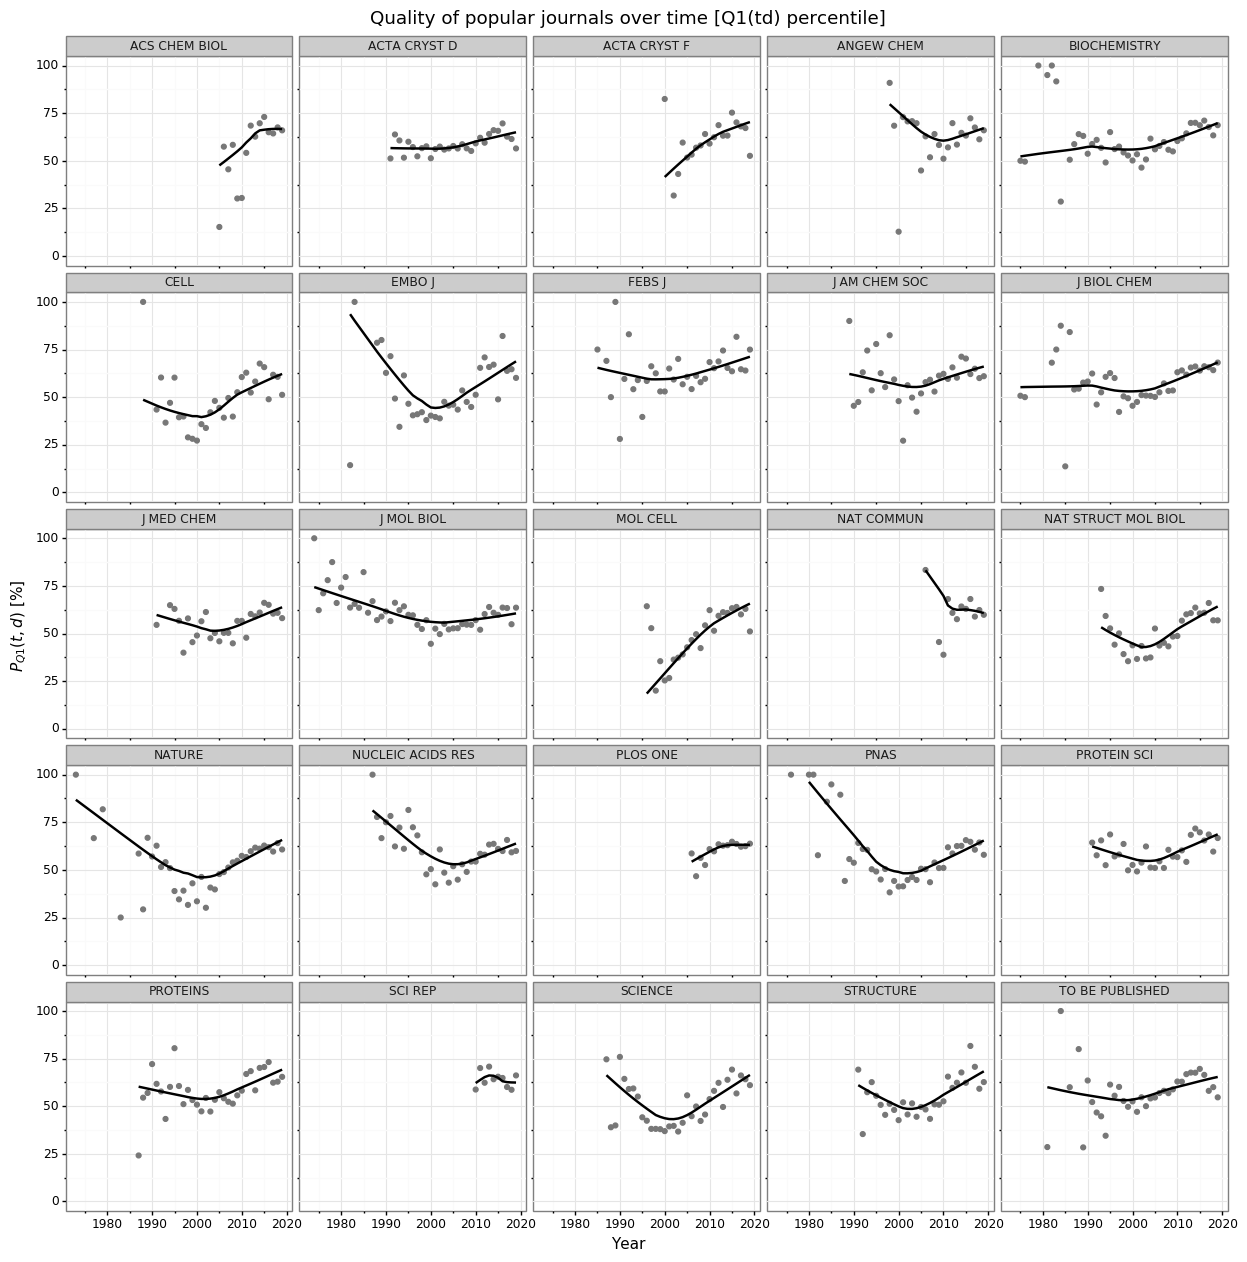

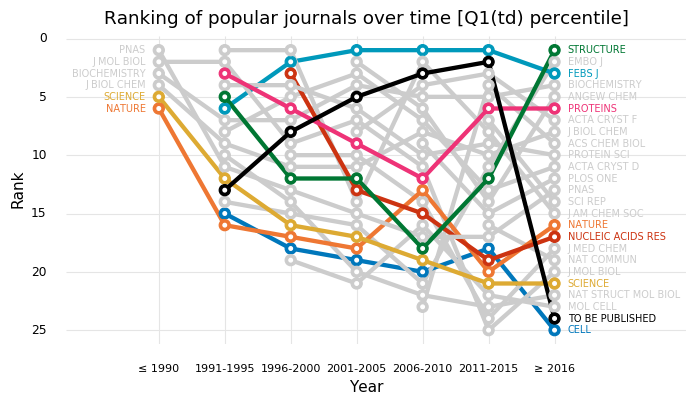

In [499]:
plot_rankings(ranking_df, "Q1(td) percentile", label="$P_{Q1}(t,d)$ [%]")

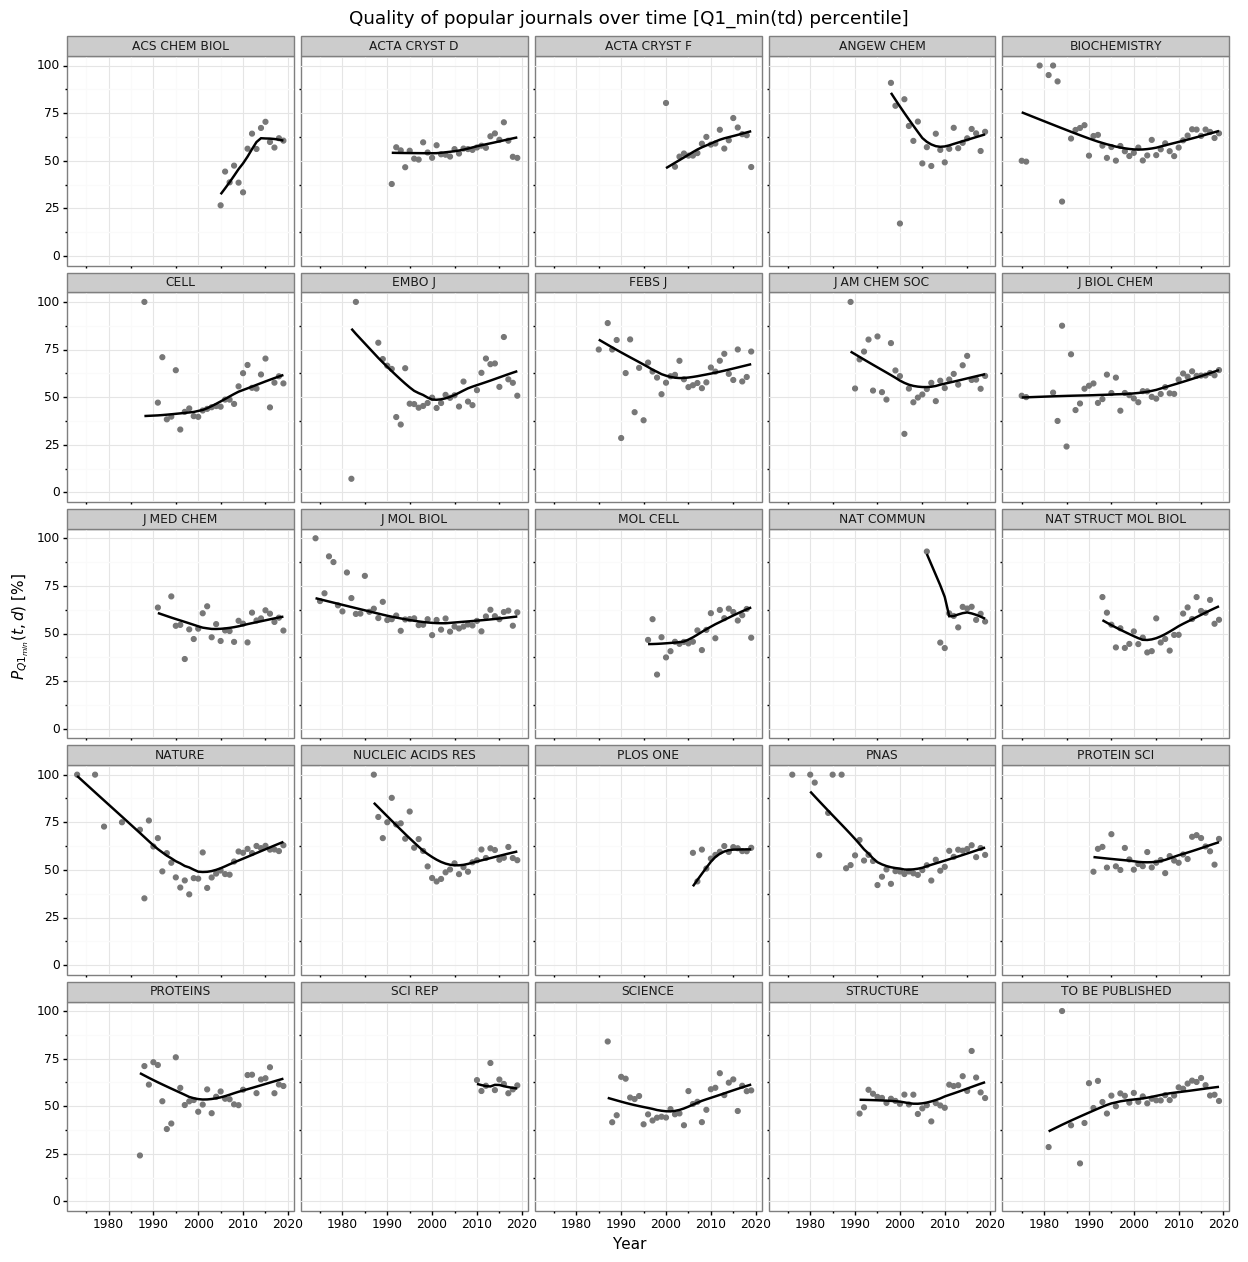

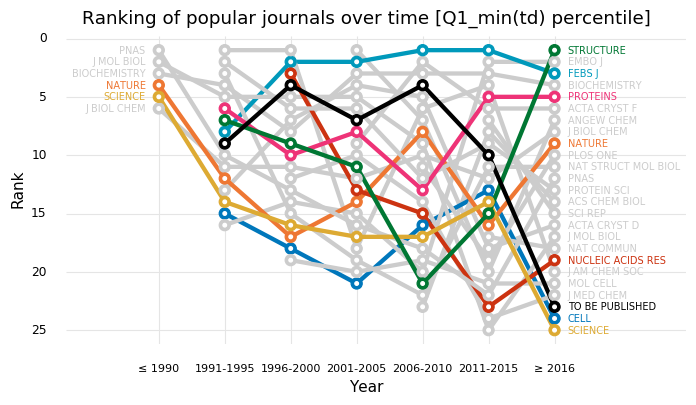

In [540]:
plot_rankings(ranking_df, "Q1_min(td) percentile", label="$P_{Q1_{min}}(t,d)$ [%]")

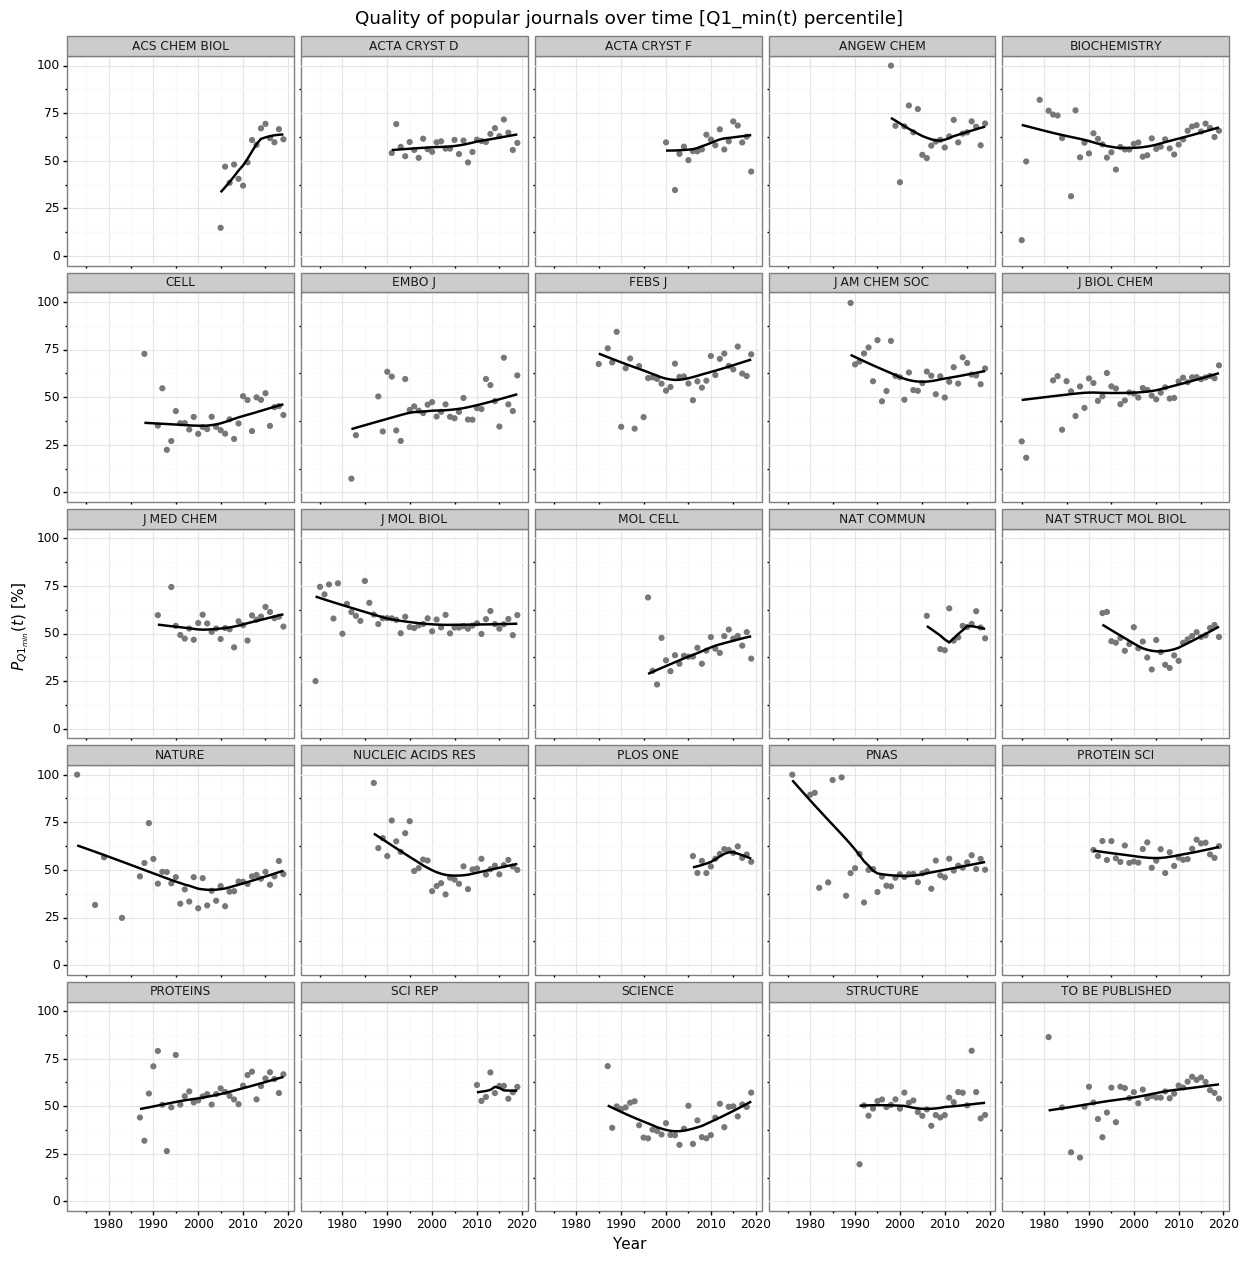

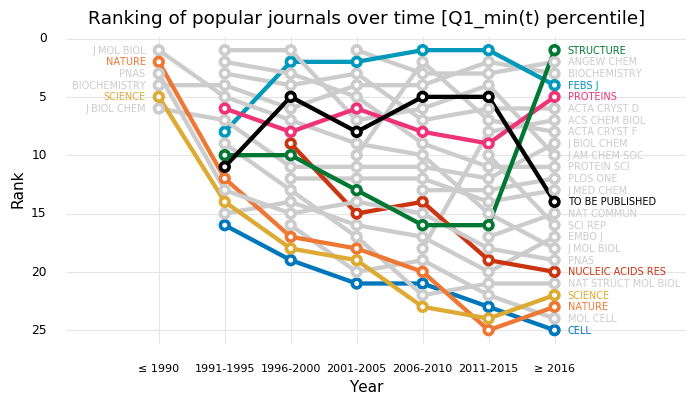

In [541]:
plot_rankings(ranking_df, "Q1_min(t) percentile", label="$P_{Q1_{min}}(t)$ [%]")

In [517]:
all_pre91 = full_quality_imputed_df.loc[full_quality_imputed_df.Year < 1991, :].shape[0]
ranked_pre91 = full_quality_imputed_df.loc[(full_quality_imputed_df.Year < 1991) & 
                            (full_quality_imputed_df.Journal.isin(["SCIENCE", "NATURE", "PNAS", "J BIOL CHEM", "J MOL BIOL", "BIOCHEMISTRY"])), :].shape[0]

Interestingly, even though only six journals reached the 30-publication threshold in the years prior to 1991, they were responsible for {{ranked_pre91}} out of {{all_pre91}} deposits.

## Comparison with Brown and Ramaswamy

Below we verify how the journals analyzed by Brown and Ramaswamy in 2007 would be ranked according to our methodology. The first ranking takes only models available as of the beginning of 2007. The second ranking shows how the journals compare if we take all the PDB data  available today.

In [500]:
br_journals = ['FEBS J', 'PROTEIN ENG DES SEL', 'BIOCHEMISTRY', 'CELL CHEM BIOL', 'PROTEINS',
               'J MOL BIOL', 'ACTA CRYST D', 'PROTEIN SCI', 'BIOORG MED CHEM LETT',
               'J STRUCT BIOL', 'BIOPHYS J', 'J BIOL INORG CHEM', 'BIOCHEM J',
               'J BIOL CHEM', 'J AM CHEM SOC', 'STRUCTURE', 'FEBS LETT', 
               'J BACTERIOL', 'BIOORG MED CHEM', 'J MED CHEM', 'NAT STRUCT MOL BIOL',
               'PNAS', 'J VIROL', 'BIOCHEM BIOPHYS RES COMMUN', 'EMBO J', 'NUCLEIC ACIDS RES', 
               'NATURE', 'MOL CELL', 'SCIENCE', 'CELL']

br_df_now = ranking_df.loc[ranking_df.Journal.isin(br_journals), :]

ranking_2007_df = journal_quality_imputed_df.loc[journal_quality_imputed_df.Year < 2007, :].copy()
venue_count_2007_df = ranking_2007_df.groupby(['Journal'], as_index=False).size()
venue_count_2007_df = venue_count_2007_df.rename("Structure count")
venue_count_2007_df = venue_count_2007_df.sort_values(ascending=False)
br_df_then = ranking_2007_df.loc[ranking_2007_df.Journal.isin(br_journals), :]

### B&R journals in 2007 according to Q1(t,d)

In [501]:
display_ranking(br_df_then, "Q1(td) percentile", venue_count_2007_df, " BR 2007")

,Journal,Significant,Q1(td) percentile,Std,A-mean resolution,G-mean resolution,V-mean resolution,Structure count
Rank,,,,,,,,
1,J BIOL INORG CHEM,False,0.596551,0.287006,1.914035,1.847459,1.825230,114
2,FEBS J,True,0.595923,0.306646,2.102242,2.050359,2.032804,356
3,PROTEIN ENG DES SEL,False,0.578044,0.306594,2.120699,2.084963,2.072969,173
4,ACTA CRYST D,True,0.563088,0.295109,1.995460,1.919657,1.894968,1766
5,BIOCHEM J,False,0.562690,0.297665,2.069630,2.019412,2.002490,165
6,FEBS LETT,False,0.561946,0.314259,2.117112,2.059887,2.040188,232
7,CELL CHEM BIOL,False,0.558707,0.293424,2.062686,2.011594,1.994906,204
8,PROTEIN SCI,True,0.554335,0.286873,2.051199,2.008550,1.994216,1104
9,BIOCHEMISTRY,True,0.553994,0.289000,2.094675,2.047292,2.031275,4564


### B&R journals now according to Q1(t,d)

In [502]:
display_ranking(br_df_now, "Q1(td) percentile", venue_count_df, " BR now")

,Journal,Significant,Q1(td) percentile,Std,A-mean resolution,G-mean resolution,V-mean resolution,Structure count
Rank,,,,,,,,
1,BIOCHEM J,True,0.654166,0.269522,2.110534,2.055753,2.037596,1033
2,FEBS J,True,0.651108,0.276463,2.022789,1.969801,1.952198,1539
3,J BIOL INORG CHEM,False,0.626033,0.285624,1.884088,1.821753,1.801113,265
4,FEBS LETT,True,0.613003,0.290949,2.101564,2.037790,2.016538,814
5,J AM CHEM SOC,True,0.608809,0.277225,2.000312,1.934786,1.912934,2369
6,PROTEIN ENG DES SEL,False,0.605922,0.295605,2.051353,2.000788,1.983931,294
7,CELL CHEM BIOL,False,0.601596,0.279872,2.077500,2.027714,2.011408,902
8,ACTA CRYST D,True,0.600510,0.284413,1.985926,1.910575,1.885989,4952
9,BIOCHEMISTRY,True,0.594411,0.284616,2.052669,2.000342,1.982907,8896


## Structural genomics projects

Finally, we took a look at structures solved by structural genomics projects. The list of deposits attributed to structural genomics projects was taken from the PDB (https://www.rcsb.org/): Advanced Search -> Deposition-> Structural Genomics Project.

In [503]:
with open("data/structural_genomics_projects_entries.txt") as f: 
    structural_genomics_pdbs = f.read().lower().split(", ")
    
structure_genomics_df = ranking_df.loc[ranking_df.loc[:, "PDB code"].isin(structural_genomics_pdbs), :]
describe(structure_genomics_df)

,PDB code,Resolution,Clashscore,Rotamer outliers [%],Ramachandran outliers [%],RSRZ outliers [%],Year,Contains protein,R [%],R free [%],Deposition date,Journal,ISSN,Q1,Q1_min,Q1 percentile,Q1_min percentile,Q1(t) percentile,Q1_min(t) percentile,Resolution group,Q1(td) percentile,Q1_min(td) percentile
2402,1gln,2.50,38.64,15.010000,4.080000,2.762097,1994.000000,True,18.500000,24.685328,1994-07-20,SCIENCE,0036-8075,0.315253,0.019523,0.213849,0.051273,0.343607,0.114952,2.500000,0.463277,0.180791
2784,1eny,2.20,19.88,22.660000,0.750000,3.679715,1995.000000,True,19.600000,26.321492,1995-01-27,SCIENCE,0036-8075,0.229080,0.036349,0.113096,0.092825,0.188510,0.174865,2.200000,0.163717,0.128319
2785,1enz,2.70,46.41,32.180000,3.010000,2.711517,1995.000000,True,19.300000,27.481384,1995-01-27,SCIENCE,0036-8075,0.238284,0.008356,0.122113,0.022529,0.202441,0.063532,2.700000,0.534247,0.205479
4966,1zid,2.70,18.61,15.760000,1.500000,1.120000,1997.000000,True,20.200000,29.700000,1997-03-25,SCIENCE,0036-8075,0.304995,0.050270,0.200459,0.125554,0.299194,0.223085,2.700000,0.564103,0.583333
5547,2lbd,2.06,14.22,9.130000,0.850000,2.940000,1997.000000,True,21.000000,31.300000,1997-08-19,NATURE,0028-0836,0.224835,0.024297,0.108911,0.063210,0.168981,0.133904,2.100000,0.111842,0.055921


Dataset rows: 12494
Dataset columns: 22


In [504]:
sg_qt_mean = structure_genomics_df.loc[:, "Q1(t) percentile"].mean()*100
sg_qtd_mean = structure_genomics_df.loc[:, "Q1(td) percentile"].mean()*100

In [513]:
all_qt_mean = ranking_df.loc[:, "Q1(t) percentile"].mean()*100
all_qtd_mean = ranking_df.loc[:, "Q1(td) percentile"].mean()*100

p_value_qt = ss.ttest_ind(structure_genomics_df.loc[:, "Q1(t) percentile"],
             ranking_df.loc[:, "Q1(t) percentile"],
             equal_var=False, 
             nan_policy='raise')[1]
p_value_qtd  = ss.ttest_ind(structure_genomics_df.loc[:, "Q1(td) percentile"],
             ranking_df.loc[:, "Q1(td) percentile"],
             equal_var=False, 
             nan_policy='raise')[1]

Below the mean Q(t) and Q(t,d) percentiles of structures solved by structure genomics projects are {{"{:.2f}".format(sg_qt_mean)}}% and {{"{:.2f}".format(sg_qtd_mean)}}%, respectively. In comparison, the Q(t) and Q(t,d) percentiles for the entire PDB are {{"{:.2f}".format(all_qt_mean)}}% and {{"{:.2f}".format(all_qtd_mean)}}%. The differences are statistically significant according to Welch's t-test with p-values {{"{0}".format(p_value_qt)}} and {{"{0}".format(p_value_qtd)}}.

In [506]:
genomics_to_be_published_df = structure_genomics_df.loc[structure_genomics_df.Journal == "TO BE PUBLISHED", :]
to_be_published_df = ranking_df.loc[ranking_df.Journal == "TO BE PUBLISHED", :]

# describe(genomics_to_be_published_df)
# describe(genomics_to_be_published_df.loc[genomics_to_be_published_df.Year >= 2016, :])
# describe(to_be_published_df)

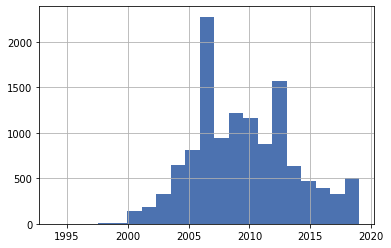

In [530]:
structure_genomics_df.Year.hist(bins=21);
# structure_genomics_df.groupby("Year", as_index=False).size().reset_index()

As a side analysis, below the number of structure genomics deposits marked as *To be published* over time. This plot allows to quantify the effect of structural genomics deposits on the quality of *To be published*.

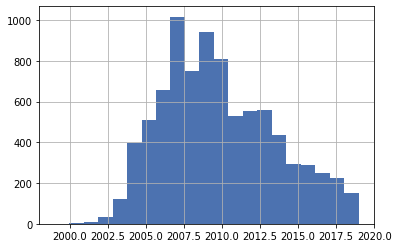

In [514]:
genomics_to_be_published_df.Year.hist(bins=21);

For comparison, the number of all deposits marked as *To be published* over time.

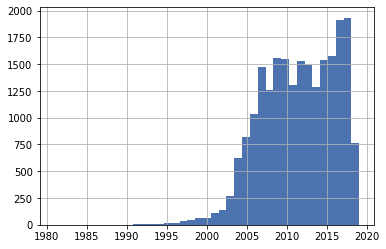

In [516]:
to_be_published_df.Year.hist(bins=39);
# genomics_to_be_published_df.loc[(genomics_to_be_published_df.Year >= 2005) & 
#                                 (genomics_to_be_published_df.Year <= 2010), :].Year.count() / to_be_published_df.loc[(to_be_published_df.Year >= 2011) & 
#                                 (to_be_published_df.Year <= 2015), :].Year.count()
# genomics_to_be_published_df.loc[(genomics_to_be_published_df.Year >= 2011) & 
#                                 (genomics_to_be_published_df.Year <= 2015), :].Year.count() / to_be_published_df.loc[(to_be_published_df.Year >= 2011) & 
#                                 (to_be_published_df.Year <= 2015), :].Year.count()
# genomics_to_be_published_df.loc[(genomics_to_be_published_df.Year >= 2016), :].Year.count() / to_be_published_df.loc[(to_be_published_df.Year >= 2016), :].Year.count()